In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import autoreload
import evotsc
import evotsc_plot
autoreload.reload(evotsc_plot)

<module 'evotsc_plot' from '/Users/theotime/Work/Code/EvoTSC/evotsc_plot.py'>

In [3]:
## Constants
# Population
nb_indivs = 100
nb_genes = 60

# Genome
intergene = 1000
interaction_dist = 2500
interaction_coef = 0.3
sigma_basal = -0.06
sigma_opt = -0.06
epsilon = 0.03
default_basal_expression = 0.5

# Environment
sigma_A = 0.1
sigma_B = -0.1

# Mutations
inversion_poisson_lam = 2.0
intergene_poisson_lam = 0.0 #2.0
intergene_mutation_var = 0.0 #1e1
basal_sc_mutation_prob = 0.0 #1e-1
basal_sc_mutation_var = 0.0 #1e-4

In [4]:
gene_types = ['AB', 'A', 'B'] # Name of each gene type
gene_type_color = ['tab:blue', 'tab:red', 'tab:green'] #AB, A, B
dpi = 300

## Example of gene transcription as a function of supercoiling 

In [5]:
# Plot the activity of an isolated gene in each environment
def plot_activity_by_sc():
    
    nb_sigmas = 100
    fig, ax = plt.subplots(figsize=(6, 4), dpi=dpi)
    ax.set_xlabel('Local supercoiling level')
    ax.set_ylabel('Gene transcription level')
    ax.set_ylim(-0.05, 1.05)
    ax.grid(linestyle=':')
    ax.invert_xaxis()

    sigmas = np.linspace(-0.25, 0.25, nb_sigmas)
    sigmas_A = sigmas + sigma_A
    sigmas_B = sigmas + sigma_B
        
    final_exprs = 1.0 / (1.0 + np.exp((sigma_basal + sigmas - sigma_opt)/epsilon))
    final_exprs_A = 1.0 / (1.0 + np.exp((sigma_basal + sigmas_A - sigma_opt)/epsilon))
    final_exprs_B = 1.0 / (1.0 + np.exp((sigma_basal + sigmas_B - sigma_opt)/epsilon))

    ax.plot(sigmas, final_exprs_B, label='$\sigma_{env}$ = ' + f'{sigma_B}')
    ax.plot(sigmas, final_exprs, label='$\sigma_{env}$ = 0')
    ax.plot(sigmas, final_exprs_A, label='$\sigma_{env}$ = ' + f'{sigma_A}')

    plt.legend()
    
    plt.savefig('activity_by_sc.pdf', dpi=dpi)
    
    plt.show()

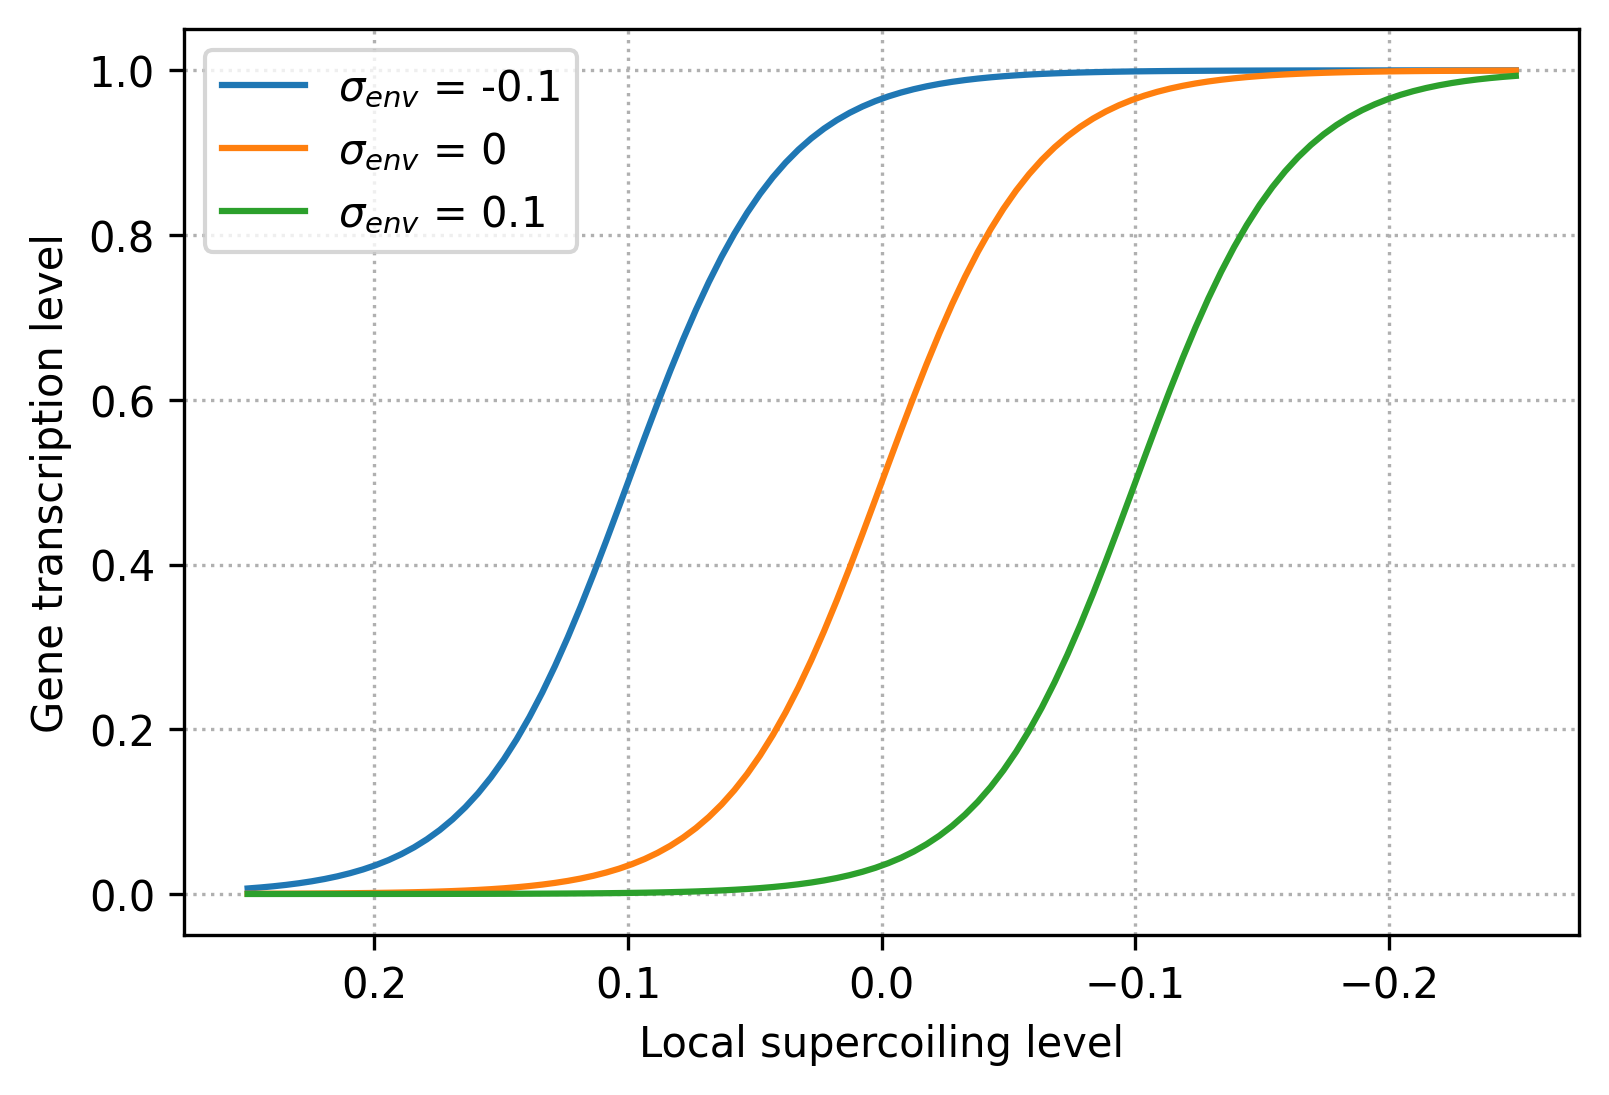

In [6]:
plot_activity_by_sc()

## Example individual with 13 genes

In [7]:
def plot_expr(indiv, temporal_expr, show_legend=True, plot_title=None, plot_name=None):

    letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    nb_genes, nb_steps = temporal_expr.shape

    colors = mpl.cm.get_cmap('viridis', indiv.nb_genes)(range(indiv.nb_genes))
    
    plt.figure(figsize=(9, 5), dpi=dpi)

    plt.ylim(-0.05, 1.05)

    for gene in range(nb_genes):
        linestyle = 'solid' if indiv.genes[gene].orientation == 0 else 'dashed'
        plt.plot(temporal_expr[indiv.genes[gene].id, :],
                 linestyle=linestyle,
                 linewidth=2,
                 color=colors[indiv.genes[gene].id],
                 #color=gene_type_color[indiv.genes[gene].gene_type],
                 label=f'Gene {letters[indiv.genes[gene].id]}')

    plt.grid(linestyle=':')
    plt.xlabel('Iteration steps', fontsize='large')
    plt.ylabel('Expression level', fontsize='large')

    if show_legend:
        plt.legend(loc='center right', ncol=2)
    
    if plot_title:
        plt.title(plot_title)

    if plot_name:
        plt.savefig(plot_name, dpi=dpi, bbox_inches='tight')   
    
    plt.show()

In [70]:
def plot_genome_and_tsc(indiv, sigma, print_ids=False, name=None):

    letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"    

    # Compute gene positions
    gene_pos, genome_length = indiv.compute_gene_positions()

    # Plot
    pos_rect = [0, 0, 1, 1]
    fig = plt.figure(figsize=(9,9), dpi=dpi)
    ax = fig.add_axes(pos_rect)

    rect_width = 0.04
    rect_height = 0.1

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    circle = plt.Circle(xy=(0, 0), radius=1, linestyle='-', fill=False)
    ax.add_patch(circle)
    ax.set_axis_off()

    ## Plot the genes themselves

    colors = mpl.cm.get_cmap('viridis', indiv.nb_genes)(range(indiv.nb_genes))
    gene_types = ['AB', 'A', 'B']

    for i_gene, gene in enumerate(indiv.genes):
        pos_angle = 360 * gene_pos[i_gene] / genome_length
        orient_angle = 360 - pos_angle
        pos_rad = np.radians(pos_angle)
        orient_rad = np.radians(orient_angle)

        ## Plot the gene rectangle

        x0 = (1.0 - rect_height / 2.0) * np.sin(pos_rad)
        y0 = (1.0 - rect_height / 2.0) * np.cos(pos_rad)


        if gene.orientation == 0:
            final_width = rect_width
        else:
            final_width = -rect_width

        rect = plt.Rectangle(xy=(x0, y0),
                             width=final_width,
                             height=rect_height,
                             angle=orient_angle, #in degrees anti-clockwise about xy.
                             facecolor=colors[gene.id],
                             edgecolor='black',
                             label=f'Gene {letters[gene.id]}')

        ax.add_patch(rect)

        ## Plot the orientation bar and arrow

        # Bar
        x_lin = (1.0 + (np.array([0.5, 1.0])) * rect_height) * np.sin(pos_rad)
        y_lin = (1.0 + (np.array([0.5, 1.0])) * rect_height) * np.cos(pos_rad)

        ax.plot(x_lin, y_lin, color='black', linewidth=1)

        # Arrow
        dx_arr = rect_width * np.cos(pos_rad) / 3.0
        dy_arr = - rect_width * np.sin(pos_rad) / 3.0

        if gene.orientation == 1: # Reverse
            dx_arr, dy_arr = -dx_arr, -dy_arr

        ax.arrow(x_lin[1], y_lin[1], dx_arr, dy_arr, head_width=0.02, color='black')

        ## Print gene ID
        if print_ids:
            
            ha_orient = ['left', 'right']
            orient = 0
            if gene.orientation == 1:
                orient = 1
            text_angle = orient_angle
            va='bottom'
            if text_angle > 90 and text_angle < 270:
                text_angle += 180
                va='top'
                orient = 1-orient
            ax.text(x=0.91*x0, y=0.91*y0, s=letters[gene.id],
                    rotation=text_angle, ha=ha_orient[orient], va=va, rotation_mode='anchor',
                    fontsize=15)

    ## Plot local supercoiling along the genome, at the end of the individual's lifecycle
    sc_ax = fig.add_axes(pos_rect, projection='polar', frameon=False)
    sc_ax.set_ylim(0, 1)

    n = 1000  # the number of data points

    # theta values (see
    # https://matplotlib.org/devdocs/gallery/images_contours_and_fields/pcolormesh_grids.html)
    # To have the crisp version: put n+1 in theta and [data] as the 3rd argument of pcolormesh()
    # To have the blurry version: put n in theta and [data, data] ----------------------------
    theta = np.linspace(0, 2 * np.pi, n)
    radius = np.linspace(.59, .71, 2)

    #data = np.array([theta[:-1]]) #np.array([np.random.random(n) * 2 * np.pi])
    positions = np.linspace(0, genome_length, n, dtype=int)
    data = indiv.compute_final_sc_at(sigma, positions)

    norm = mpl.colors.Normalize(-2.0, 2.0) # Extremum values for the SC level

    data = -data # Reverse data to get blue = positive and red = negative SC
        
    mesh = sc_ax.pcolormesh(theta, radius, [data, data], shading='gouraud',
                     norm=norm, cmap=plt.get_cmap('seismic'))
    sc_ax.set_yticklabels([])
    sc_ax.set_xticklabels([])
    #sc_ax.spines['polar'].set_visible(False)
    sc_ax.set_theta_zero_location('N')
    sc_ax.set_theta_direction('clockwise')
    
    # Color bar for the SC level
    cbar = fig.colorbar(mesh, ax=[ax, sc_ax], shrink=0.7, pad=0.0, location='left')
    cbar.set_label('σ', fontsize=20)
    cbar.ax.invert_yaxis()
    cbar.ax.tick_params(labelsize=15) 
    
    ## Legend: the gene interaction distance
    line_len = np.pi*indiv.interaction_dist/genome_length
    line_y = -0.1
    ax.plot([-line_len, line_len], [line_y, line_y],
             color='black',
             linewidth=1)
    ax.text(0, line_y - 0.07, 'Gene interaction distance', ha='center', fontsize=15)

    ## Wrapping up
    if name:
        plt.savefig(name, dpi=300, bbox_inches='tight')

    plt.show()

    plt.close()


In [9]:
rng = np.random.default_rng(seed=0xA71F3_06)

ex_genes = evotsc.Gene.generate(intergene=intergene,
                                nb_genes=13,
                                default_basal_expression=default_basal_expression)

for gene in ex_genes:
    gene.basal_expression = rng.random()

# Match the genome in the figure (leading: 0, lagging: 1)
ex_genes[0].orientation = 1
ex_genes[1].orientation = 0
ex_genes[2].orientation = 0
ex_genes[3].orientation = 1
ex_genes[4].orientation = 0
ex_genes[5].orientation = 0
ex_genes[6].orientation = 1
ex_genes[7].orientation = 1
ex_genes[8].orientation = 0
ex_genes[9].orientation = 1
ex_genes[10].orientation = 0
ex_genes[11].orientation = 0
ex_genes[12].orientation = 0

ex_indiv = evotsc.Individual(genes=ex_genes,
                             interaction_dist=interaction_dist,
                             interaction_coef=interaction_coef,
                             sigma_basal=sigma_basal,
                             sigma_opt=sigma_opt,
                             epsilon=epsilon)

_ = ex_indiv.evaluate(sigma_A, sigma_B)

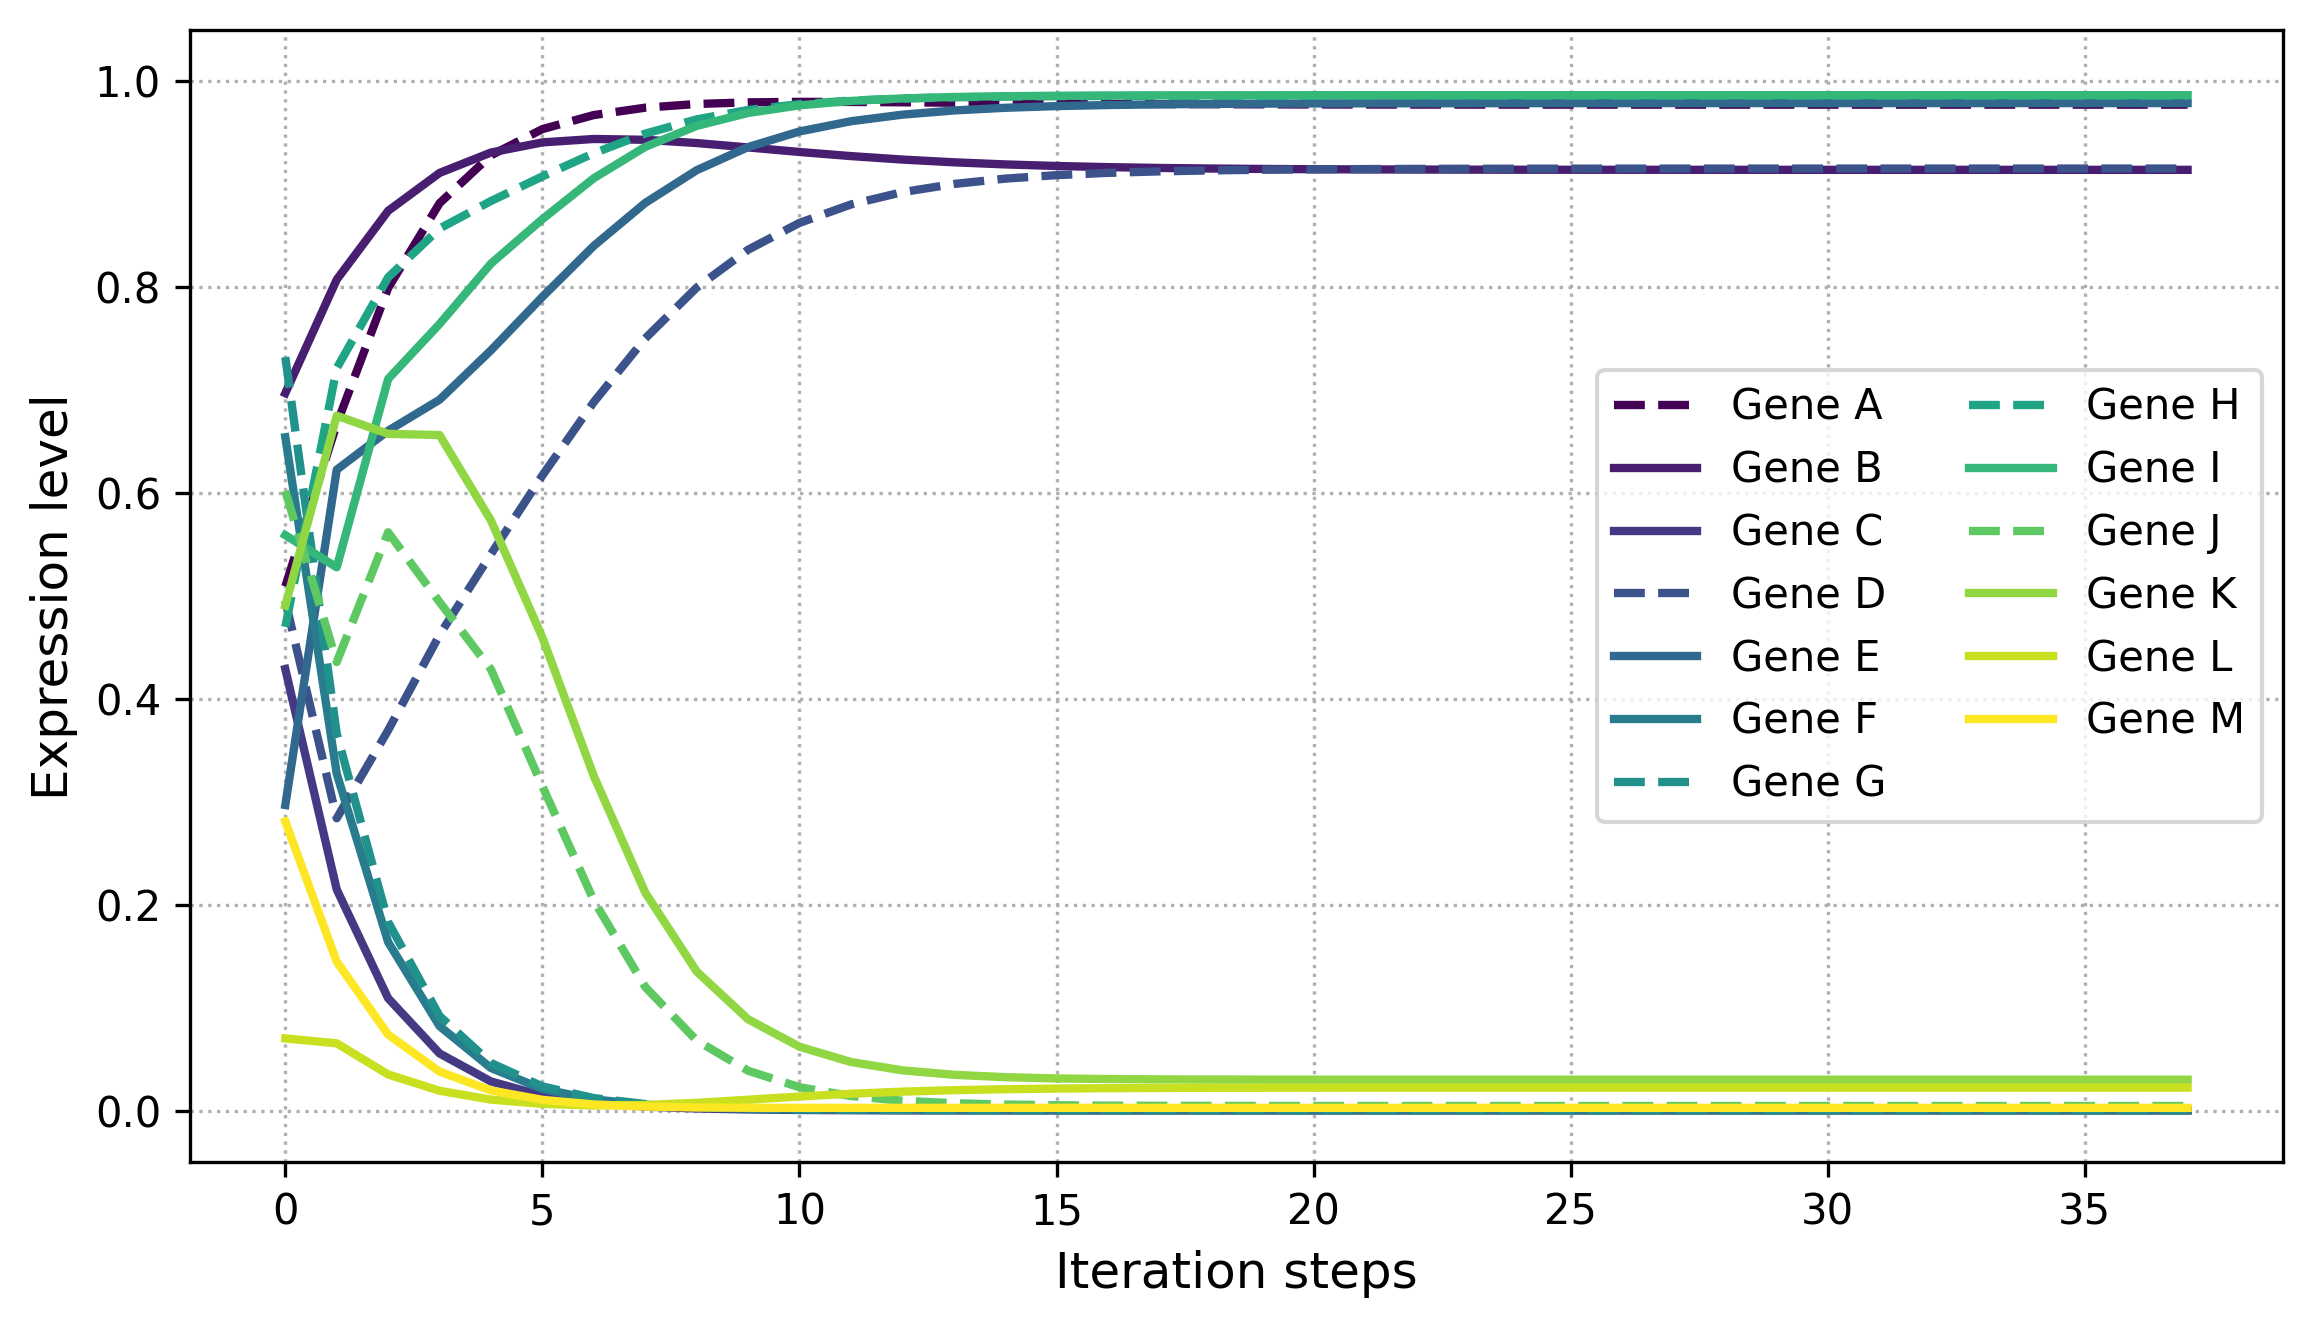

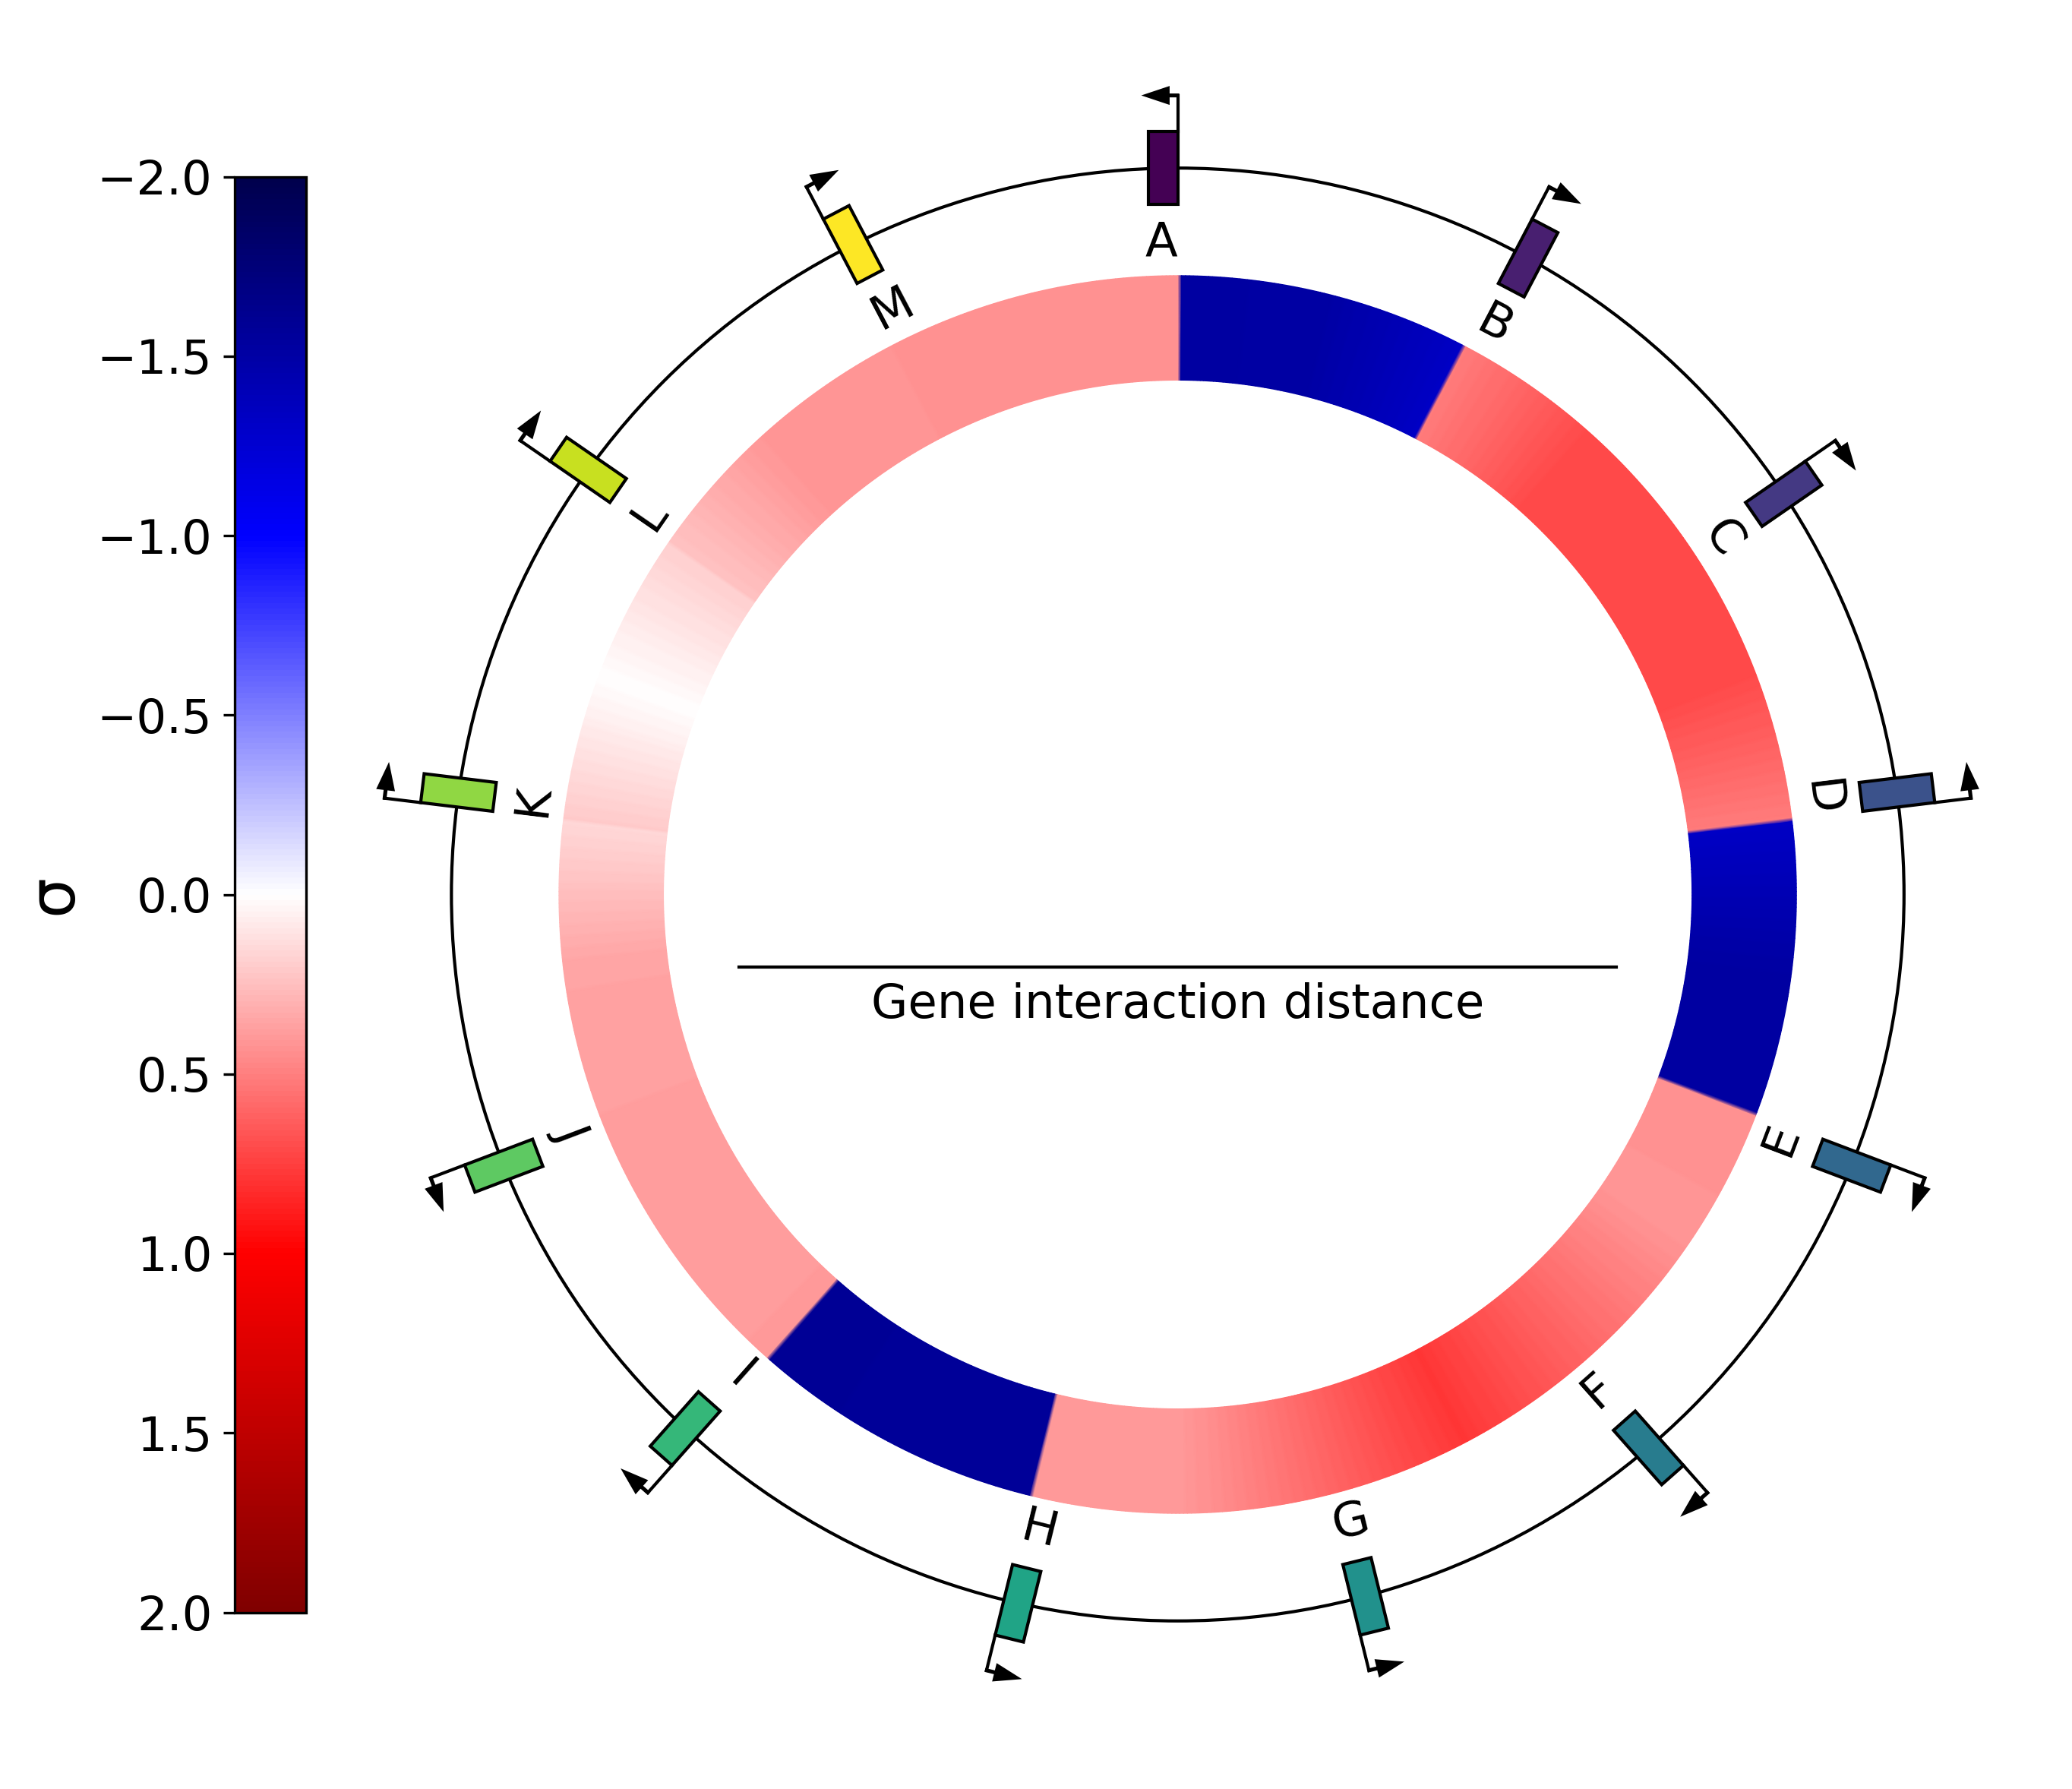

In [71]:
sigma_ex = 0.05
plot_expr(ex_indiv, ex_indiv.run_system(sigma_ex), plot_name='13genes_expr_level.pdf')
plot_genome_and_tsc(ex_indiv, sigma_ex, print_ids=True, name='13genes_genome.pdf')

## Example individual in different environments

SC -0.2: 10 on


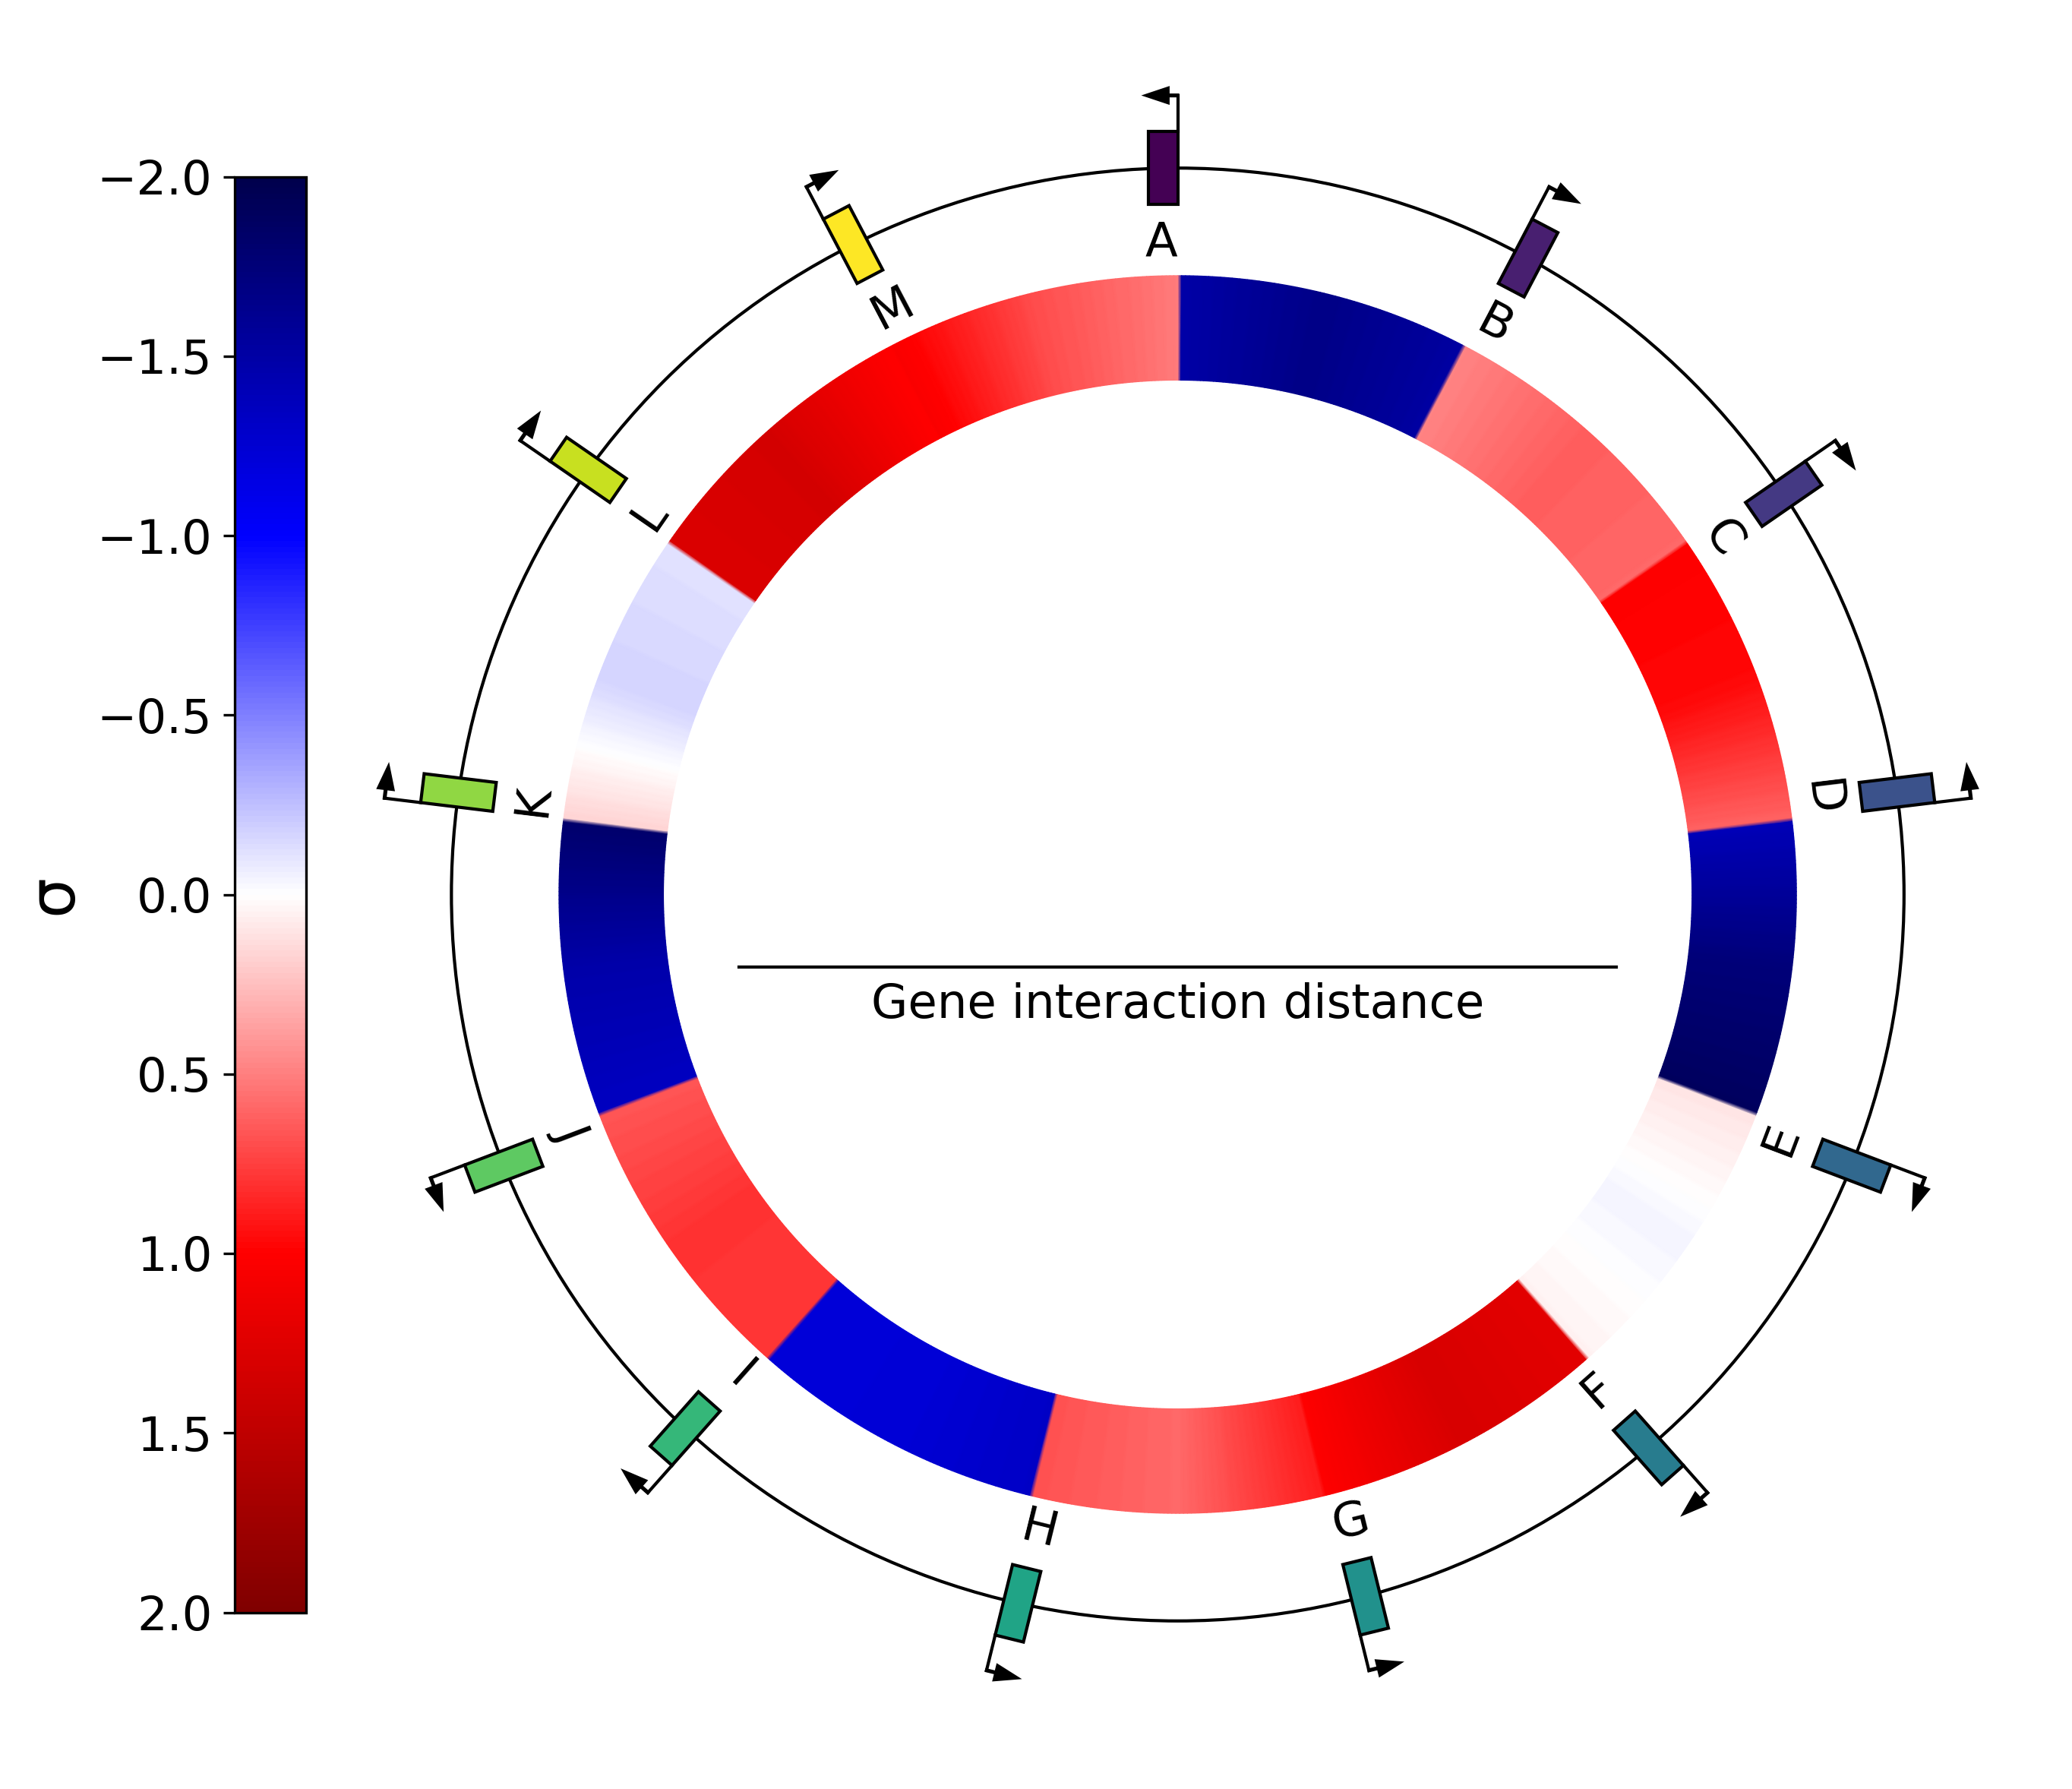

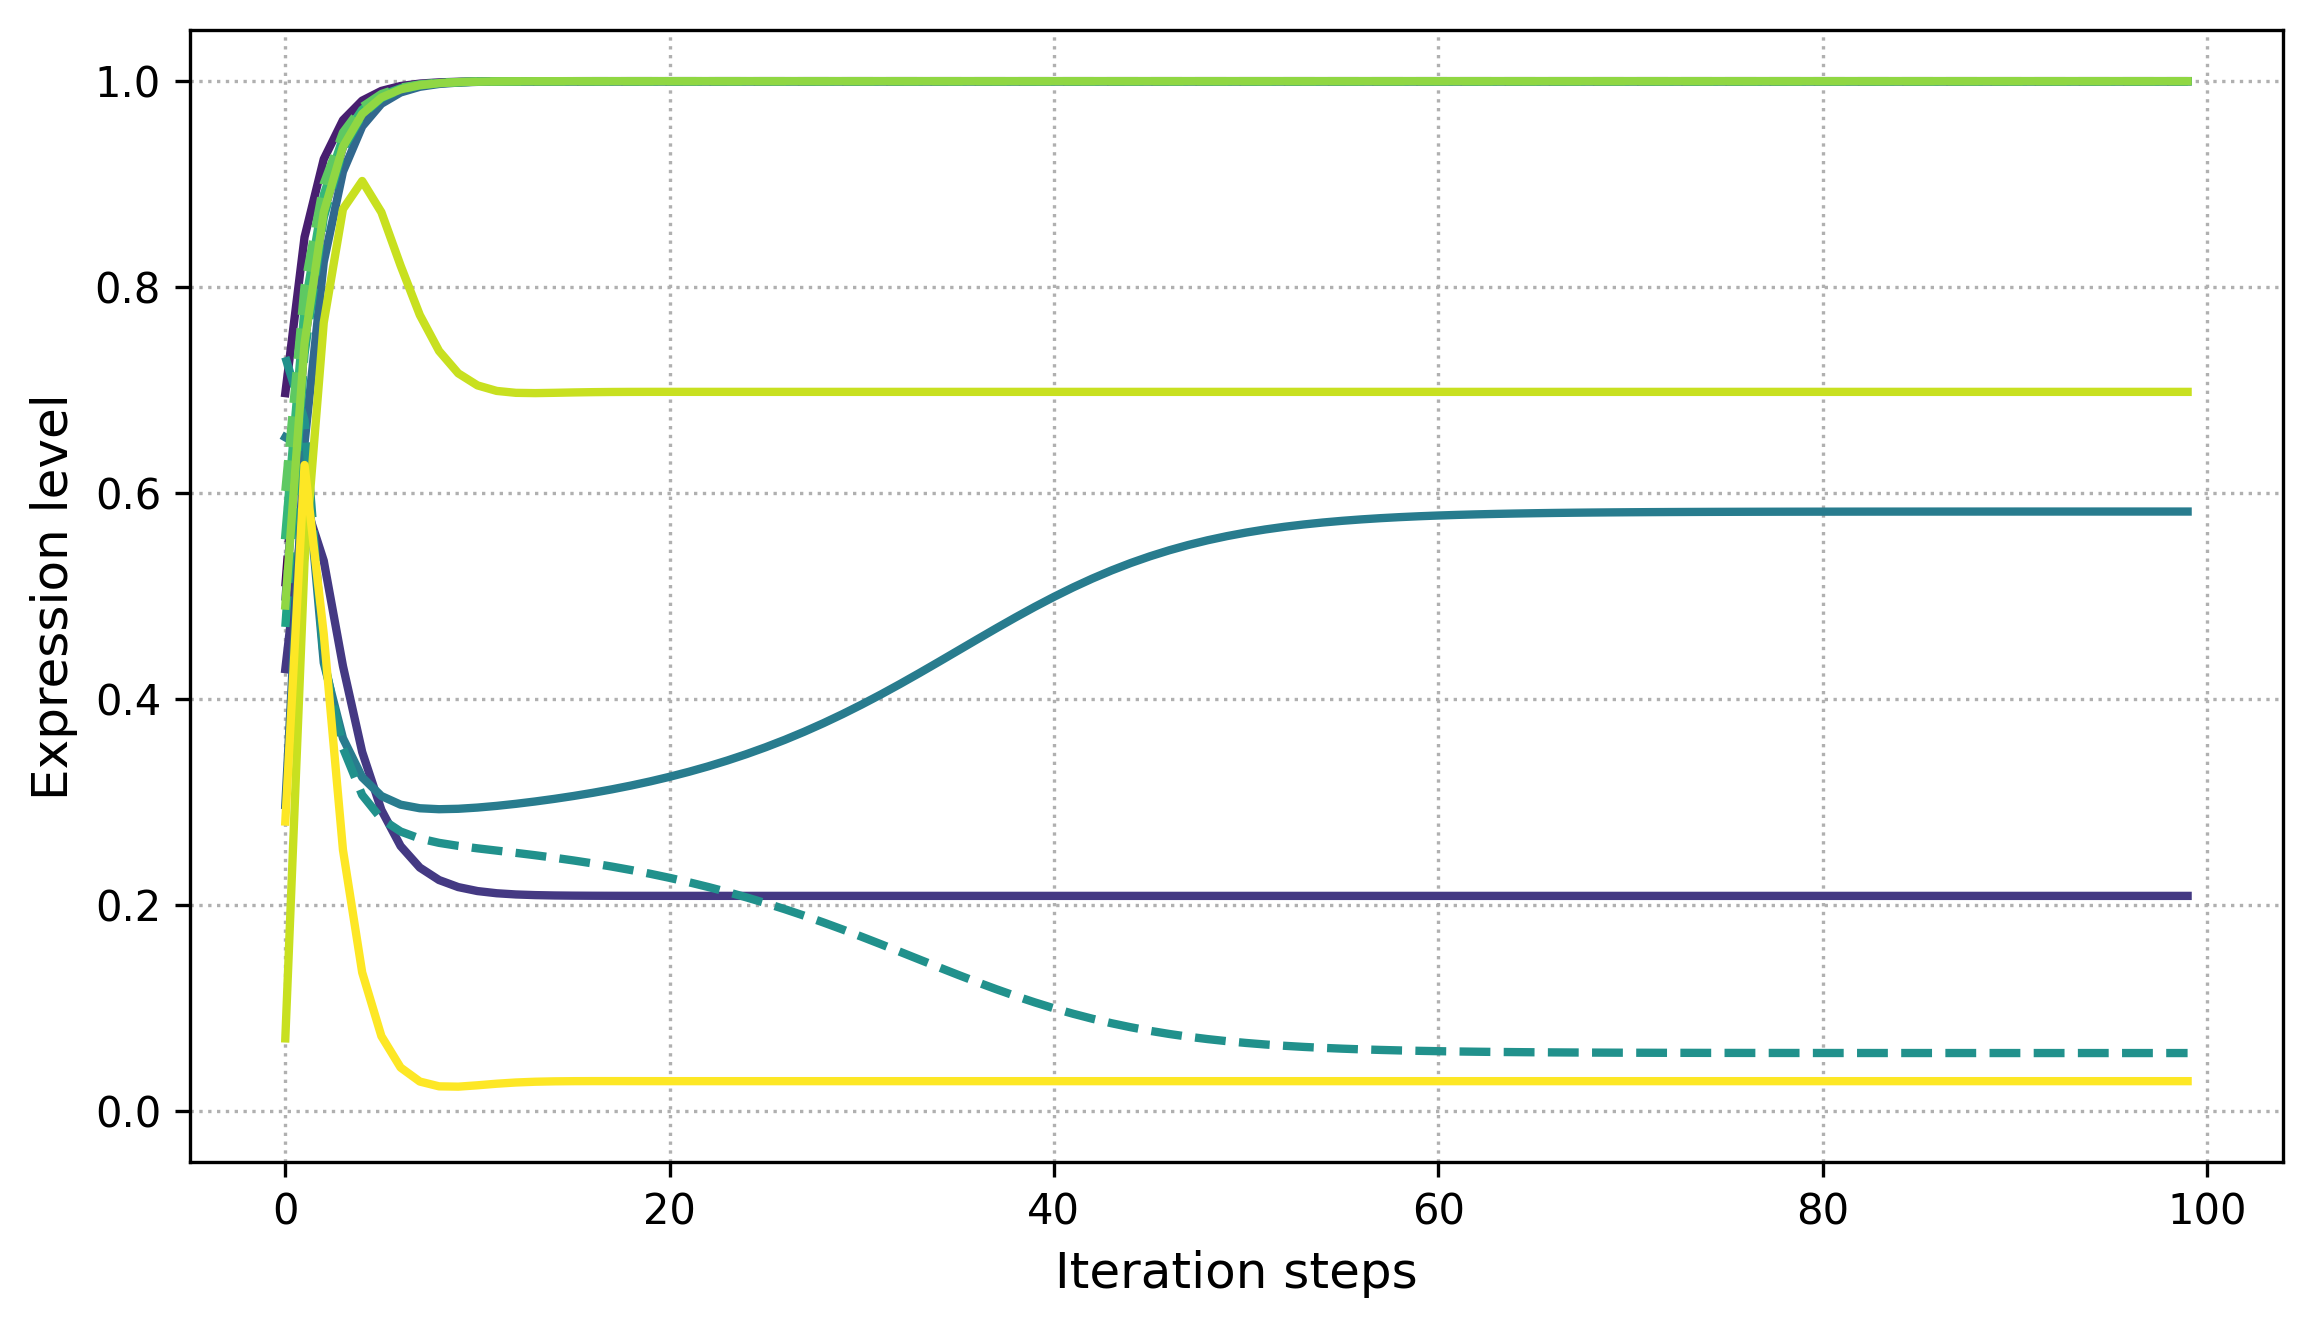

SC -0.1: 8 on


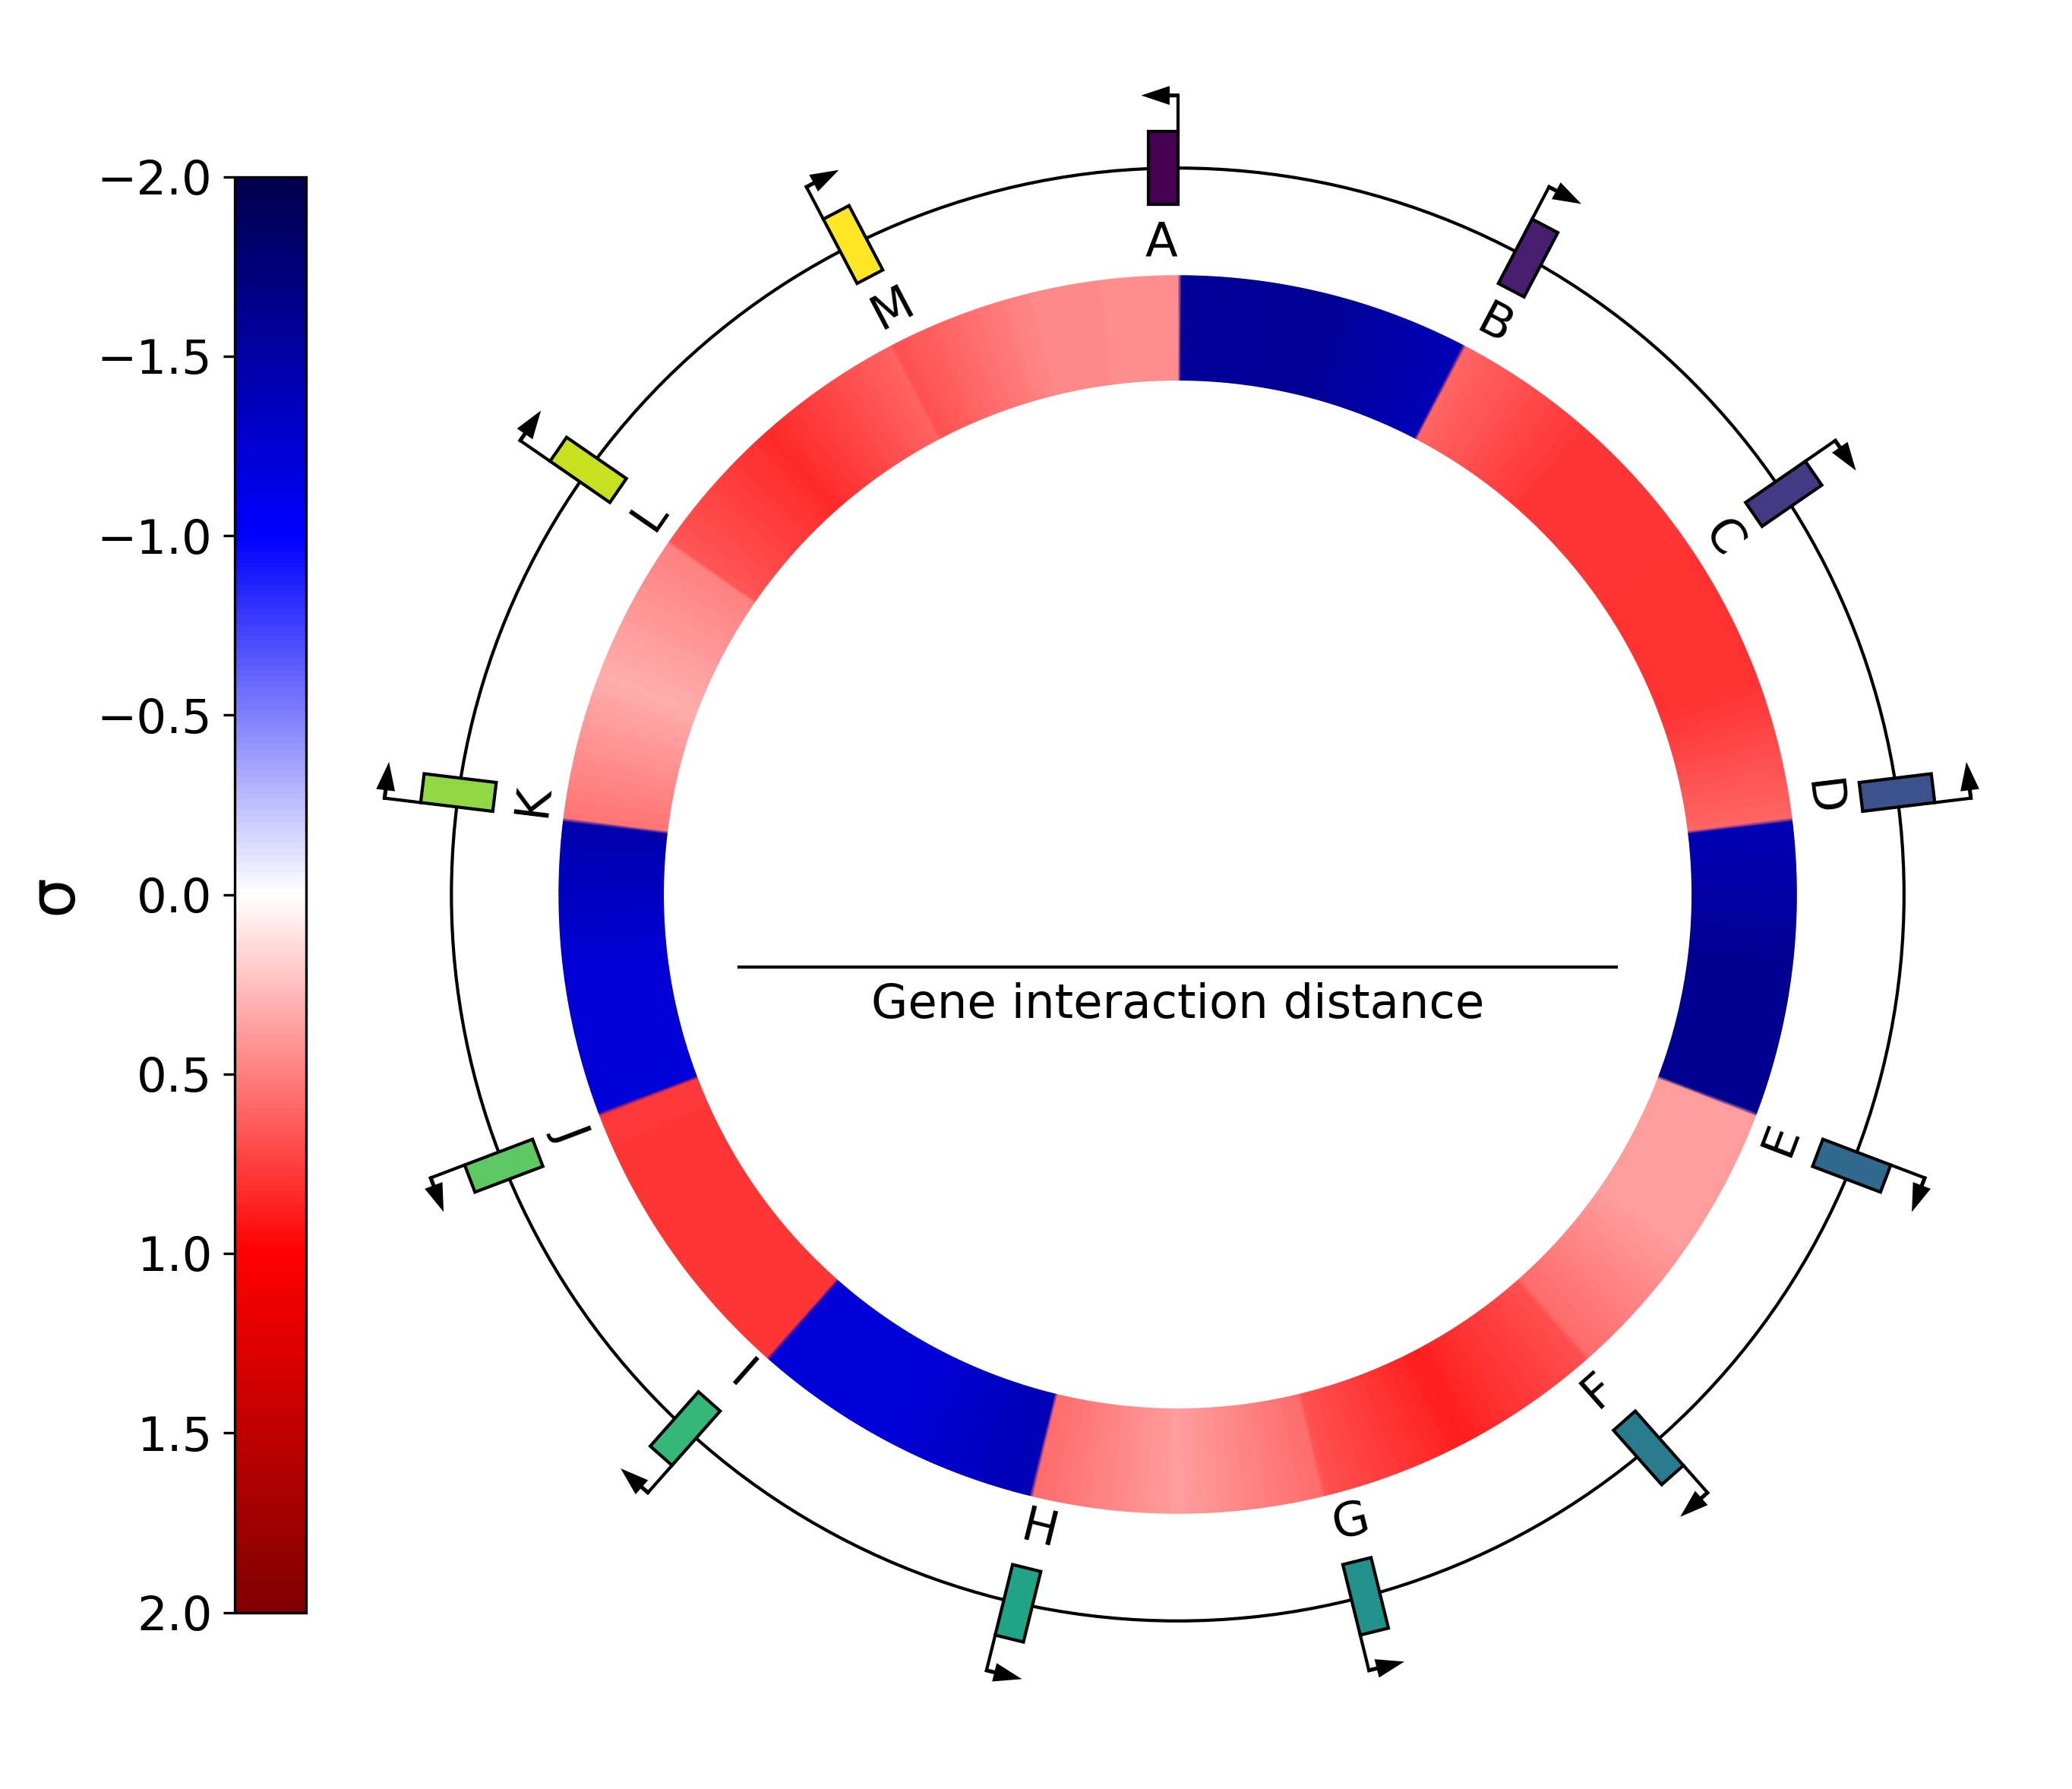

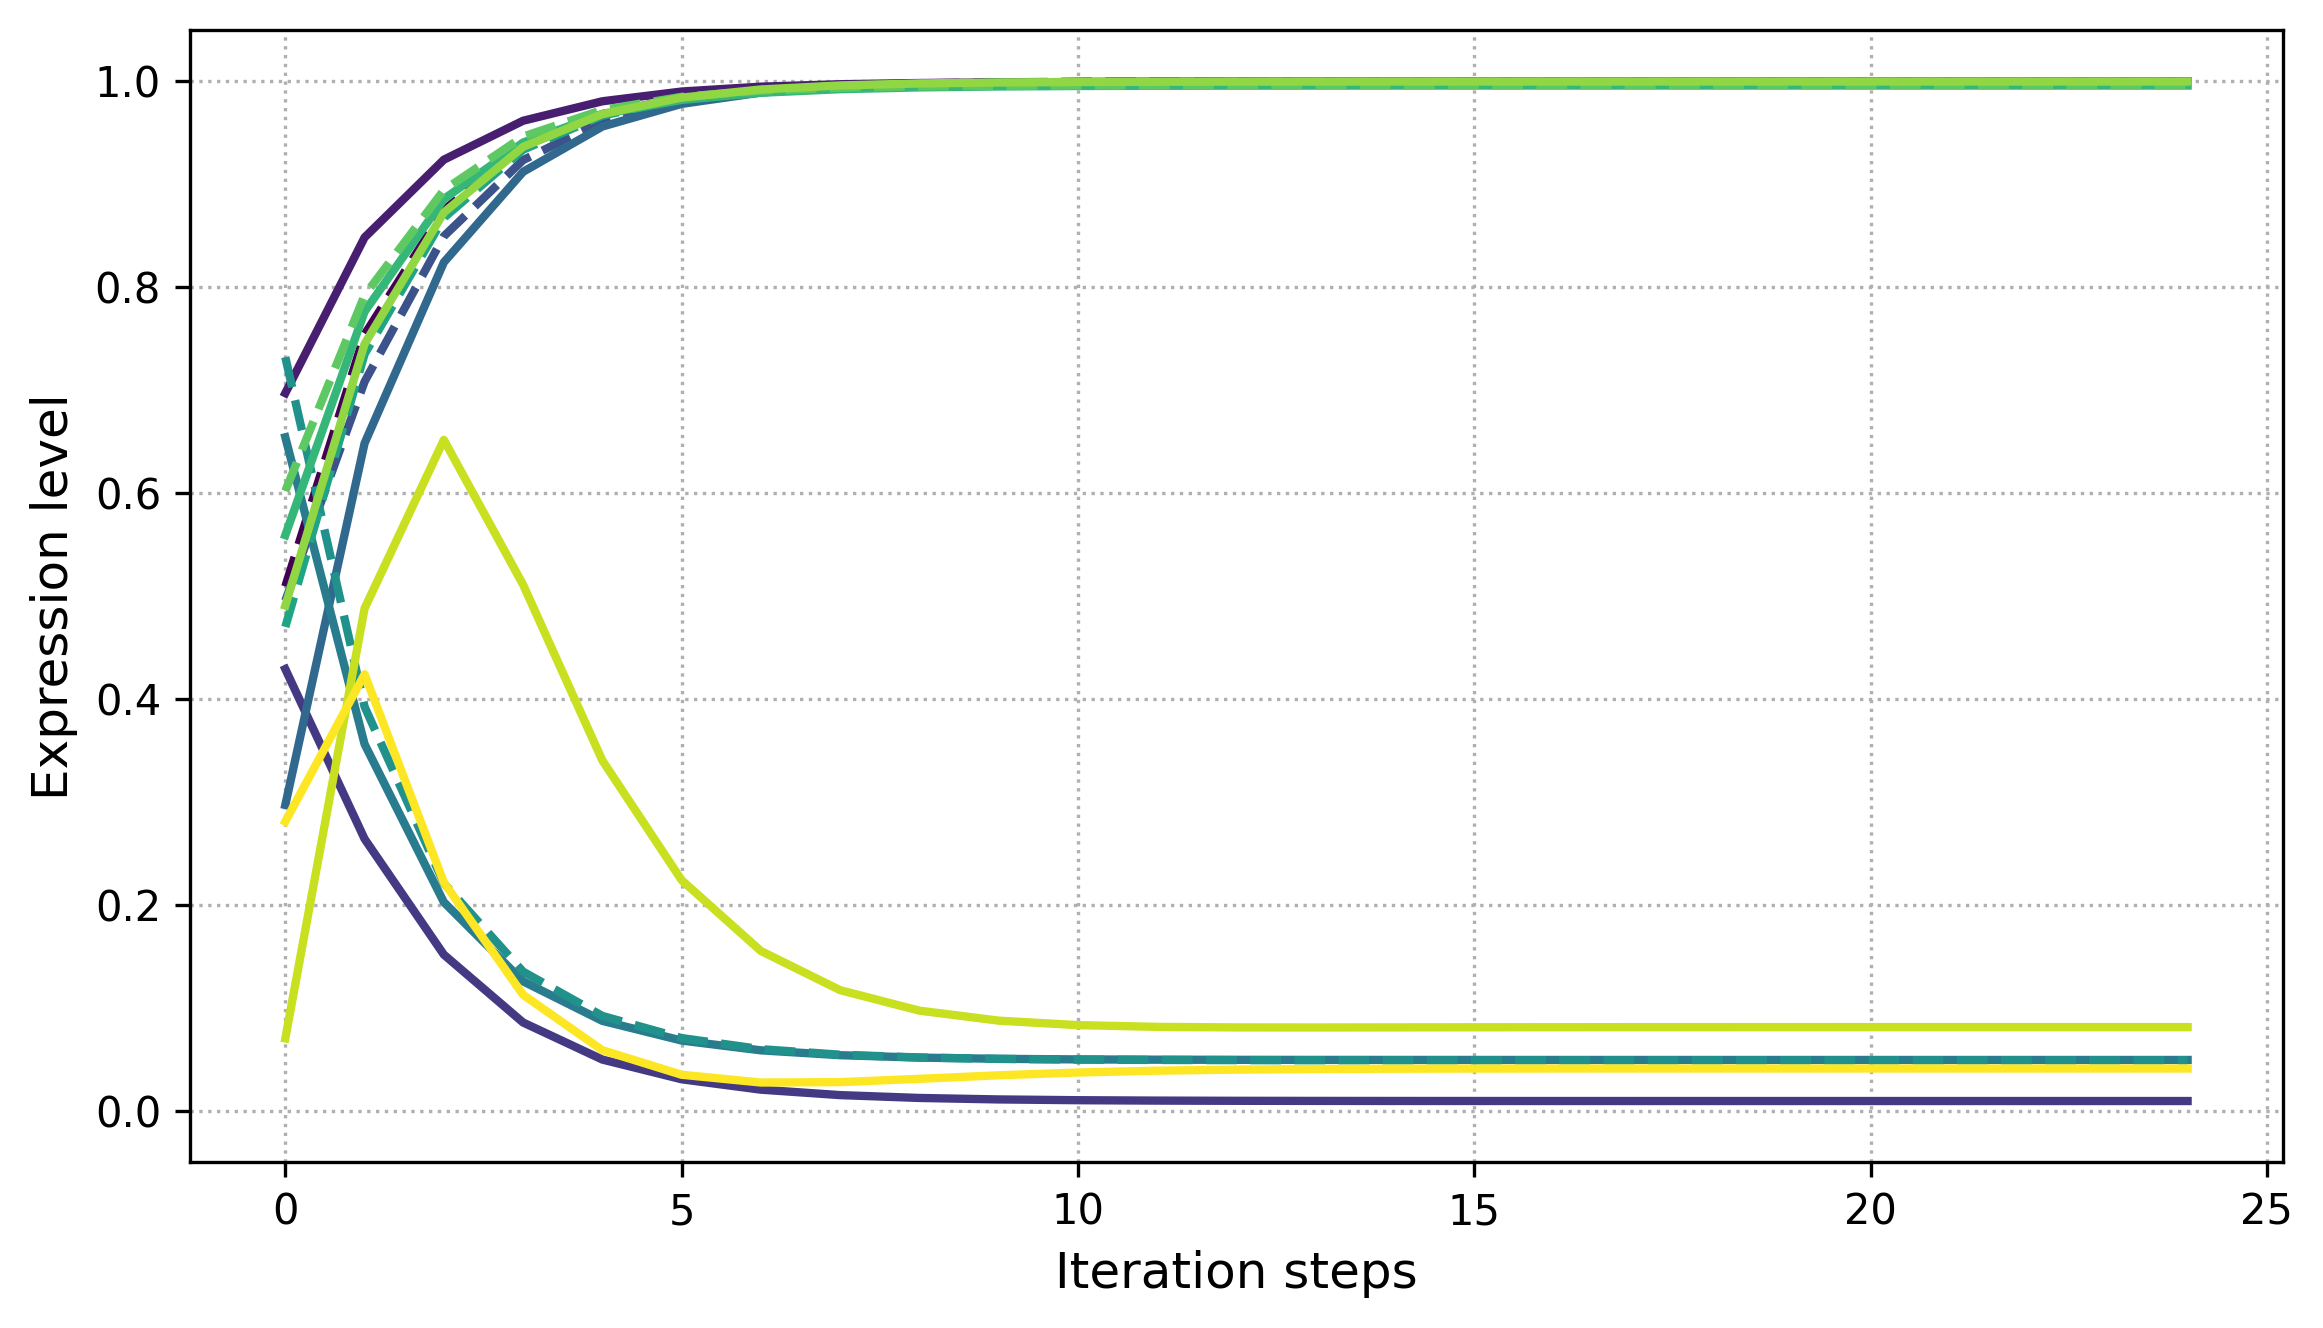

SC 0.0: 8 on


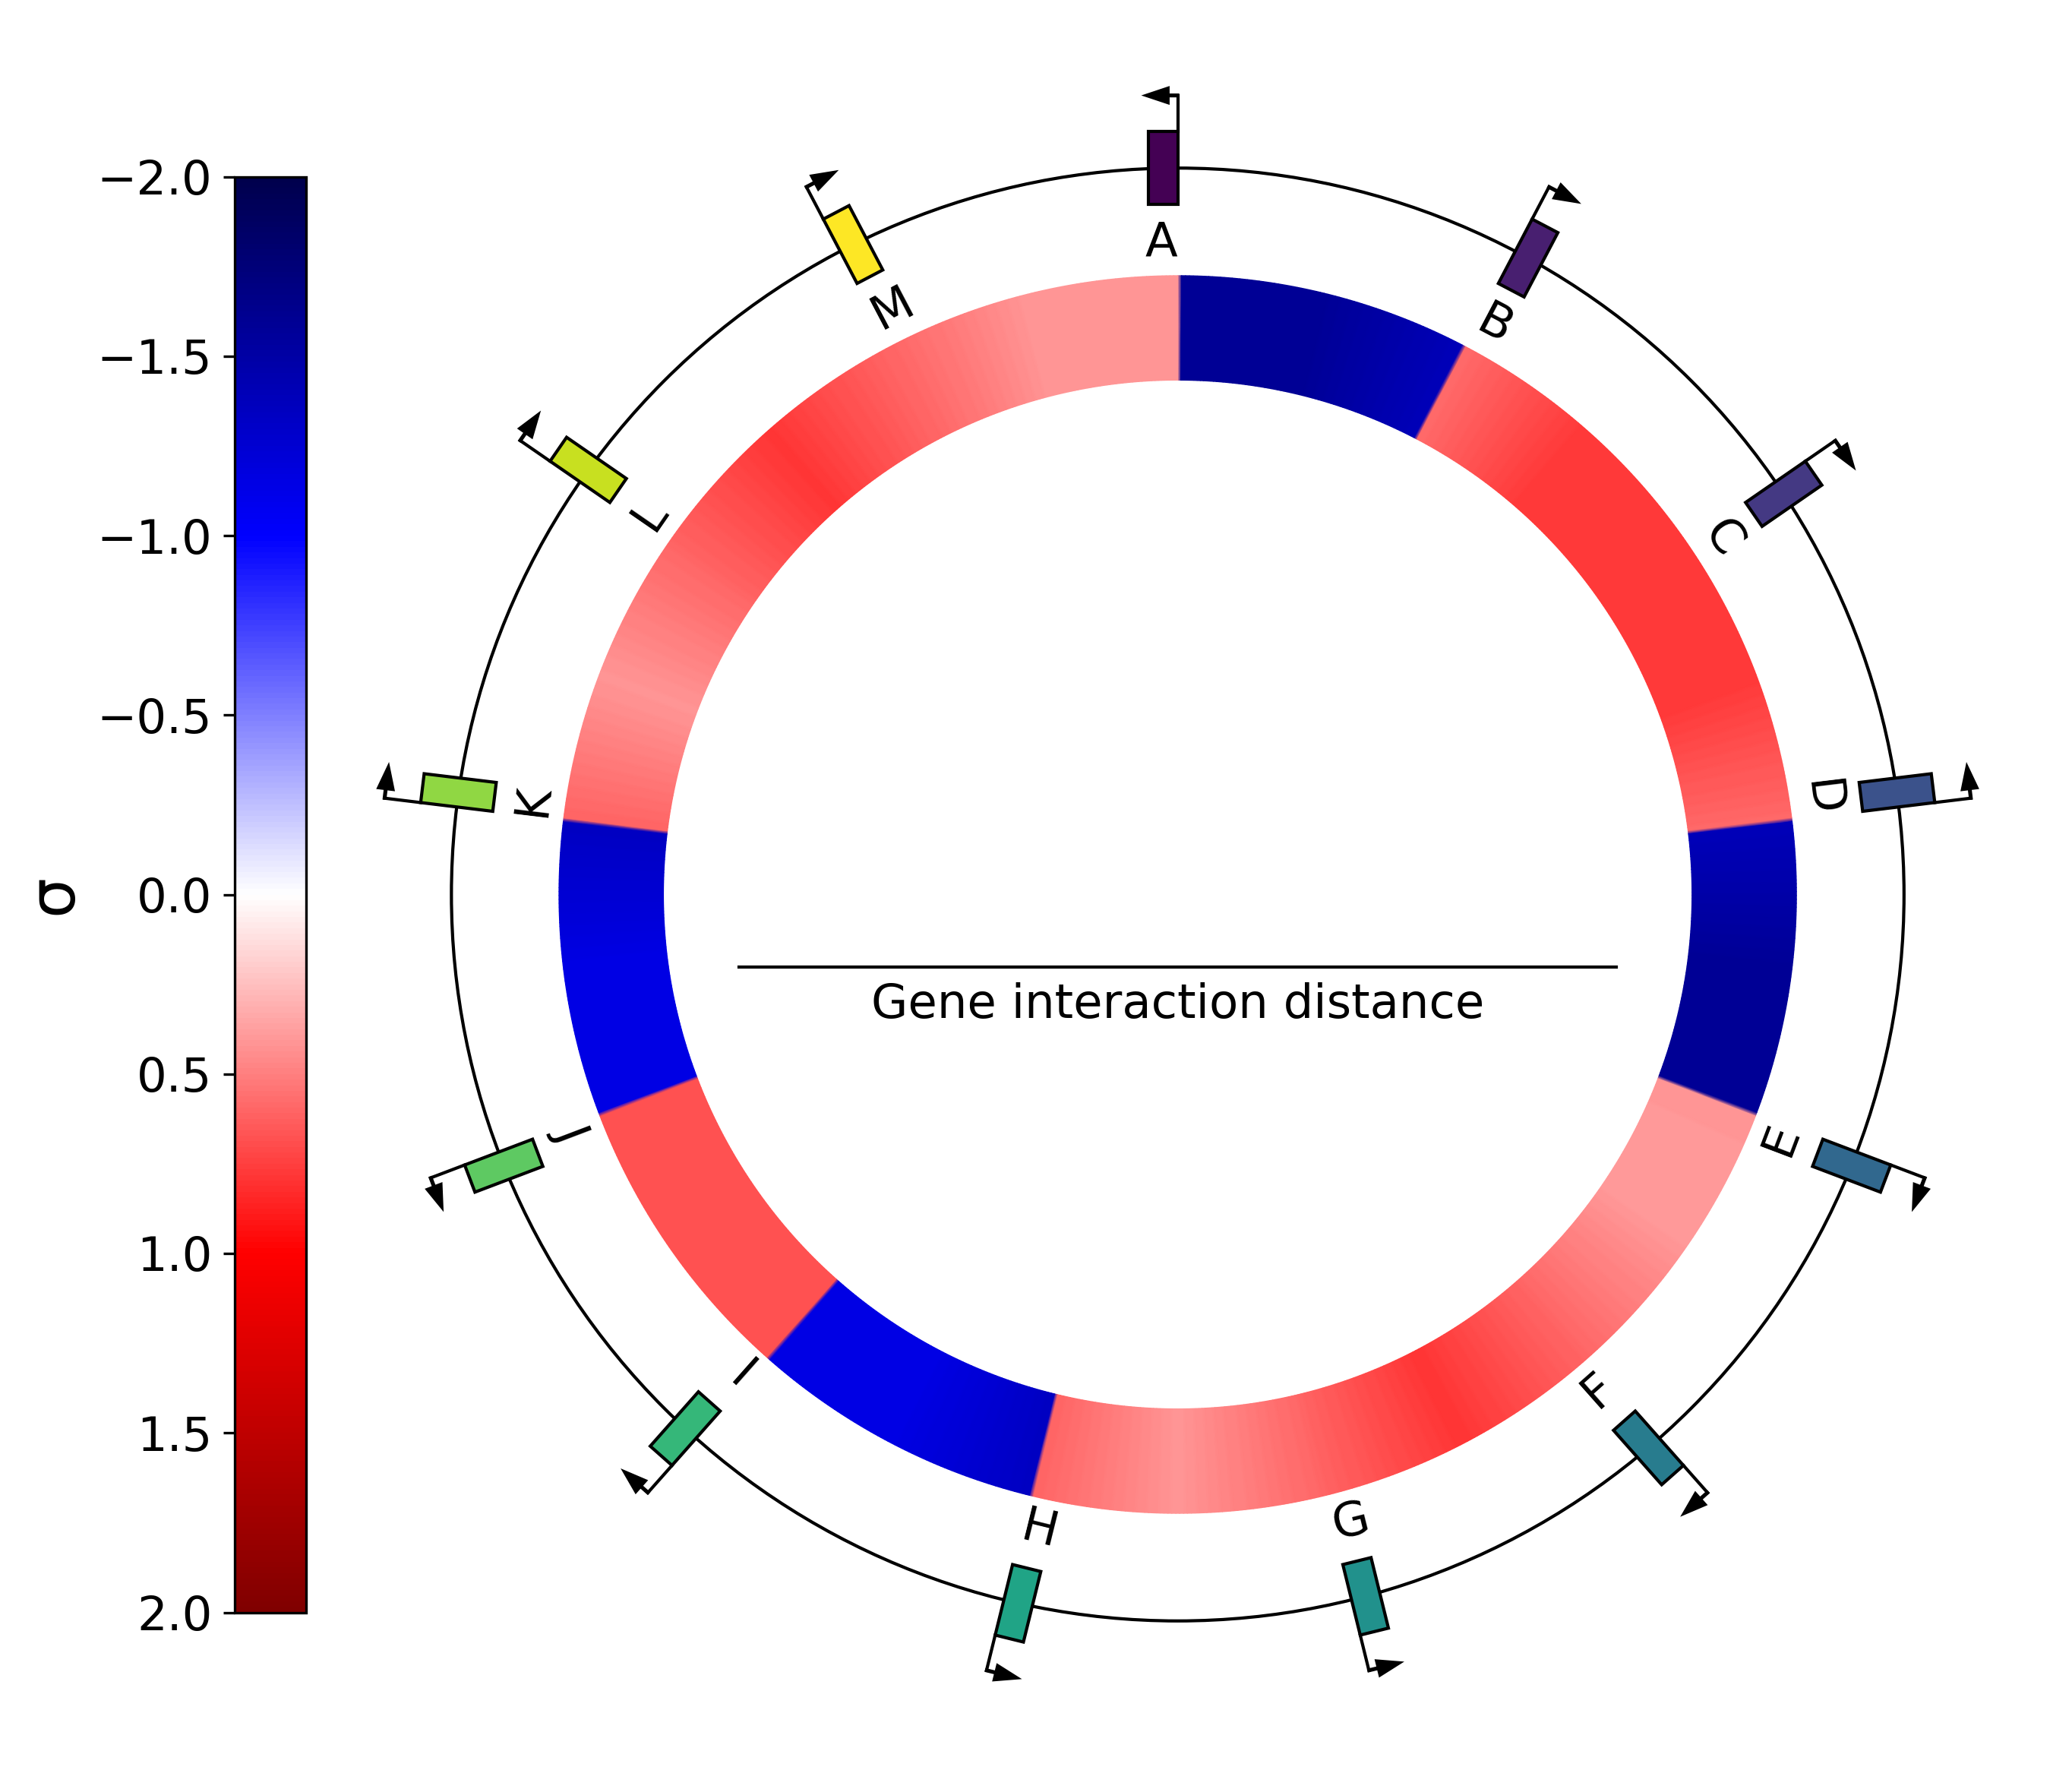

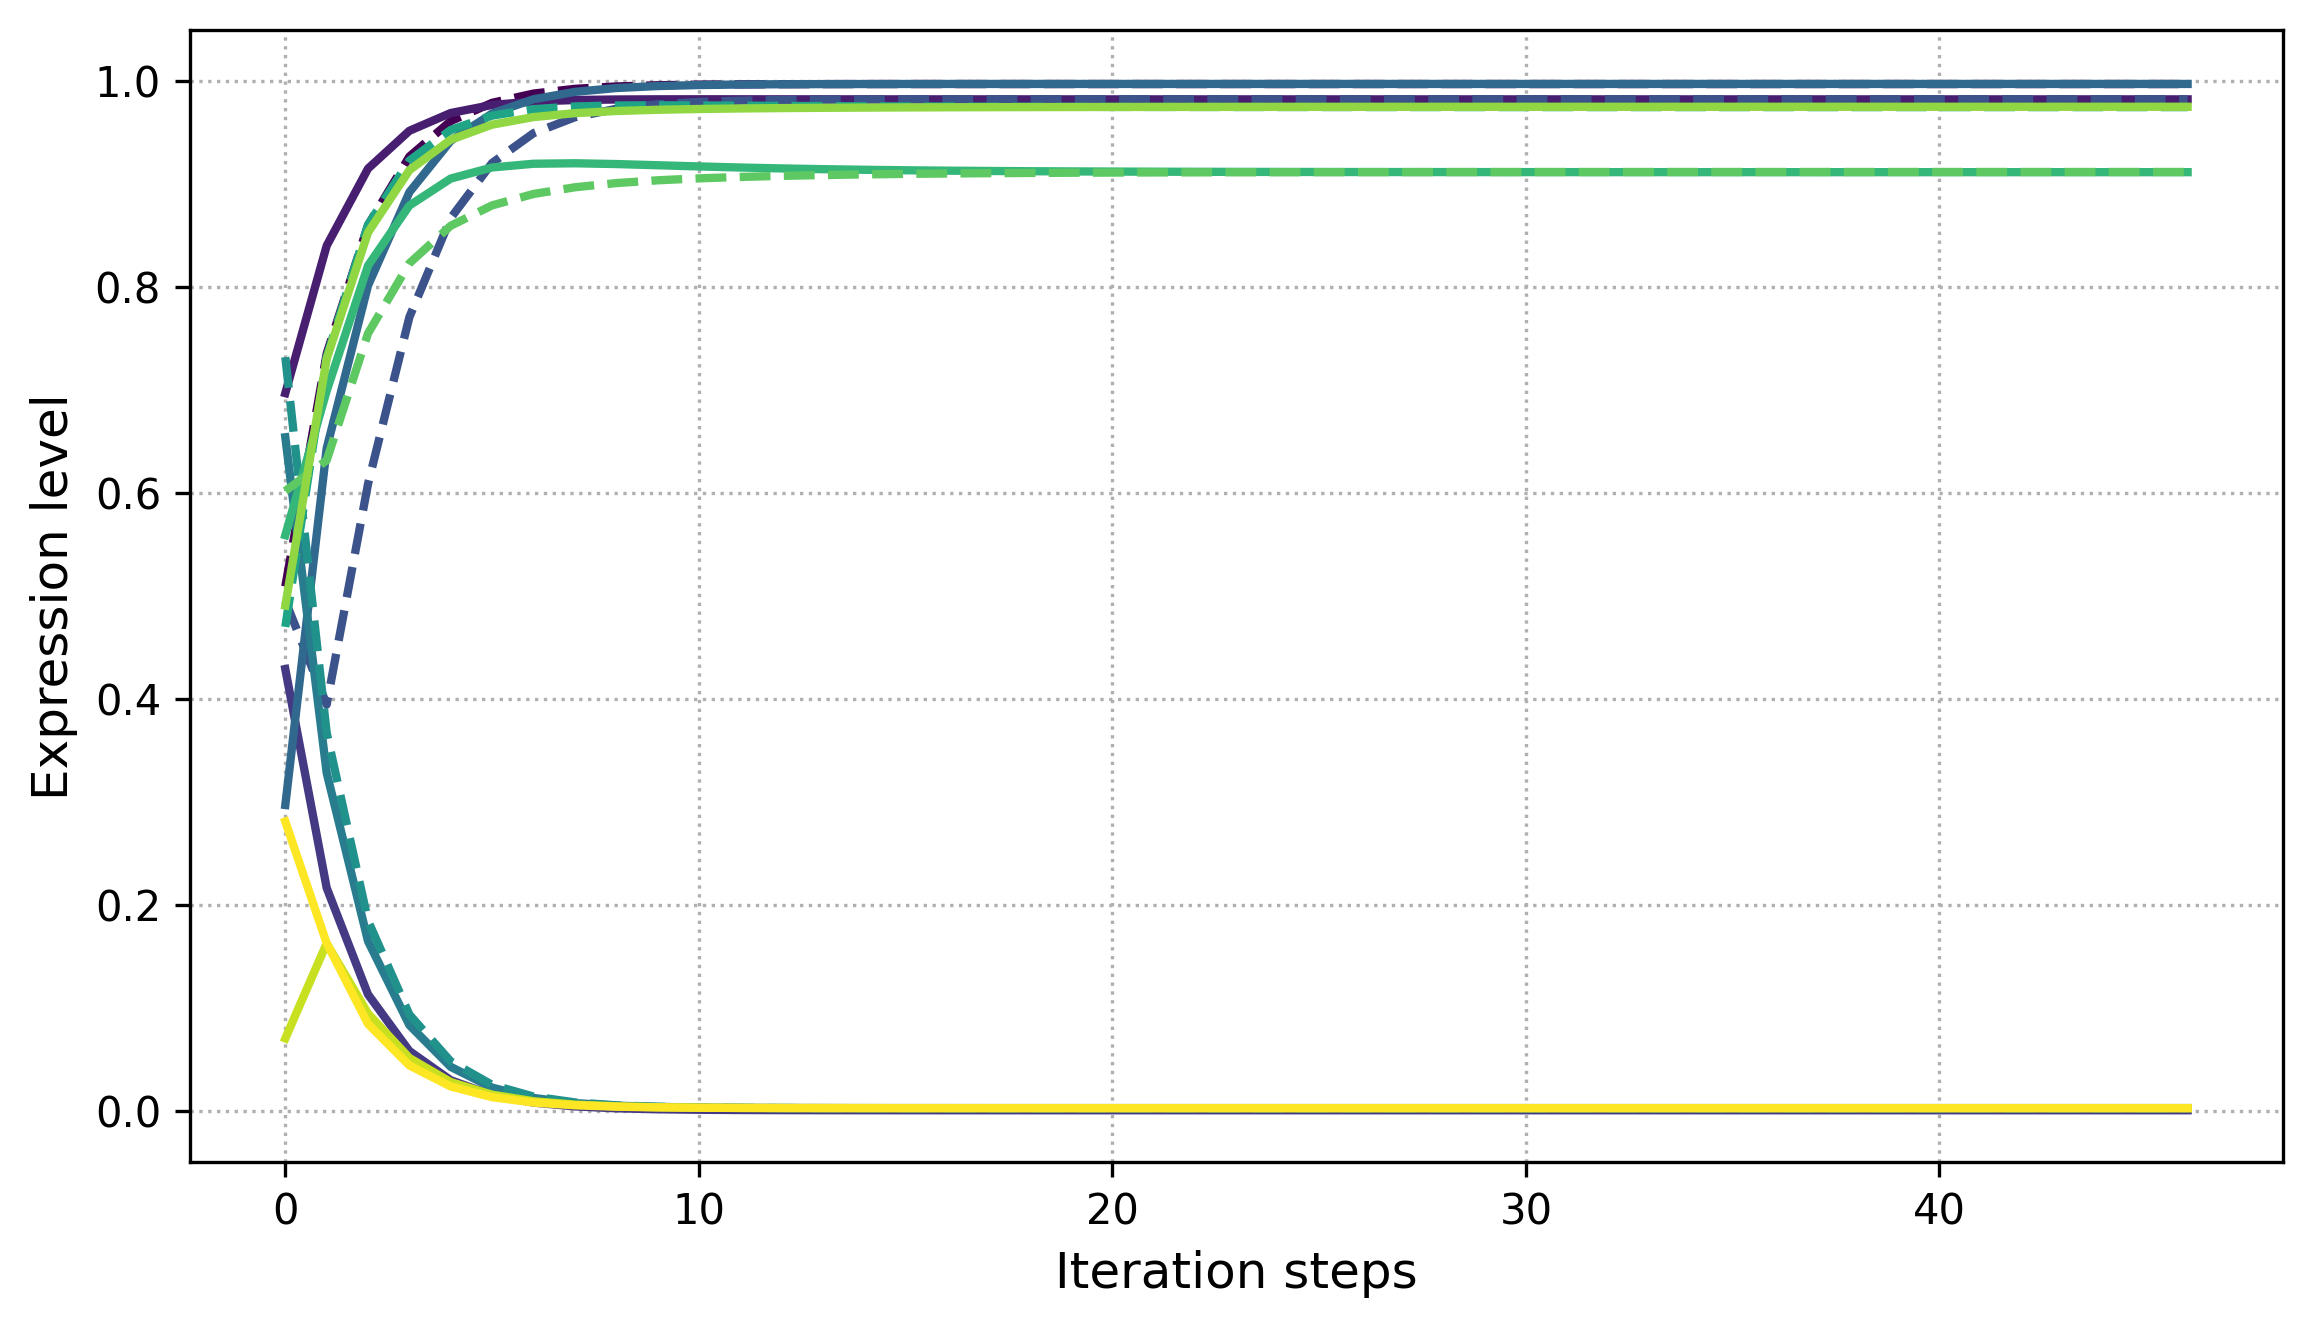

SC 0.1: 0 on


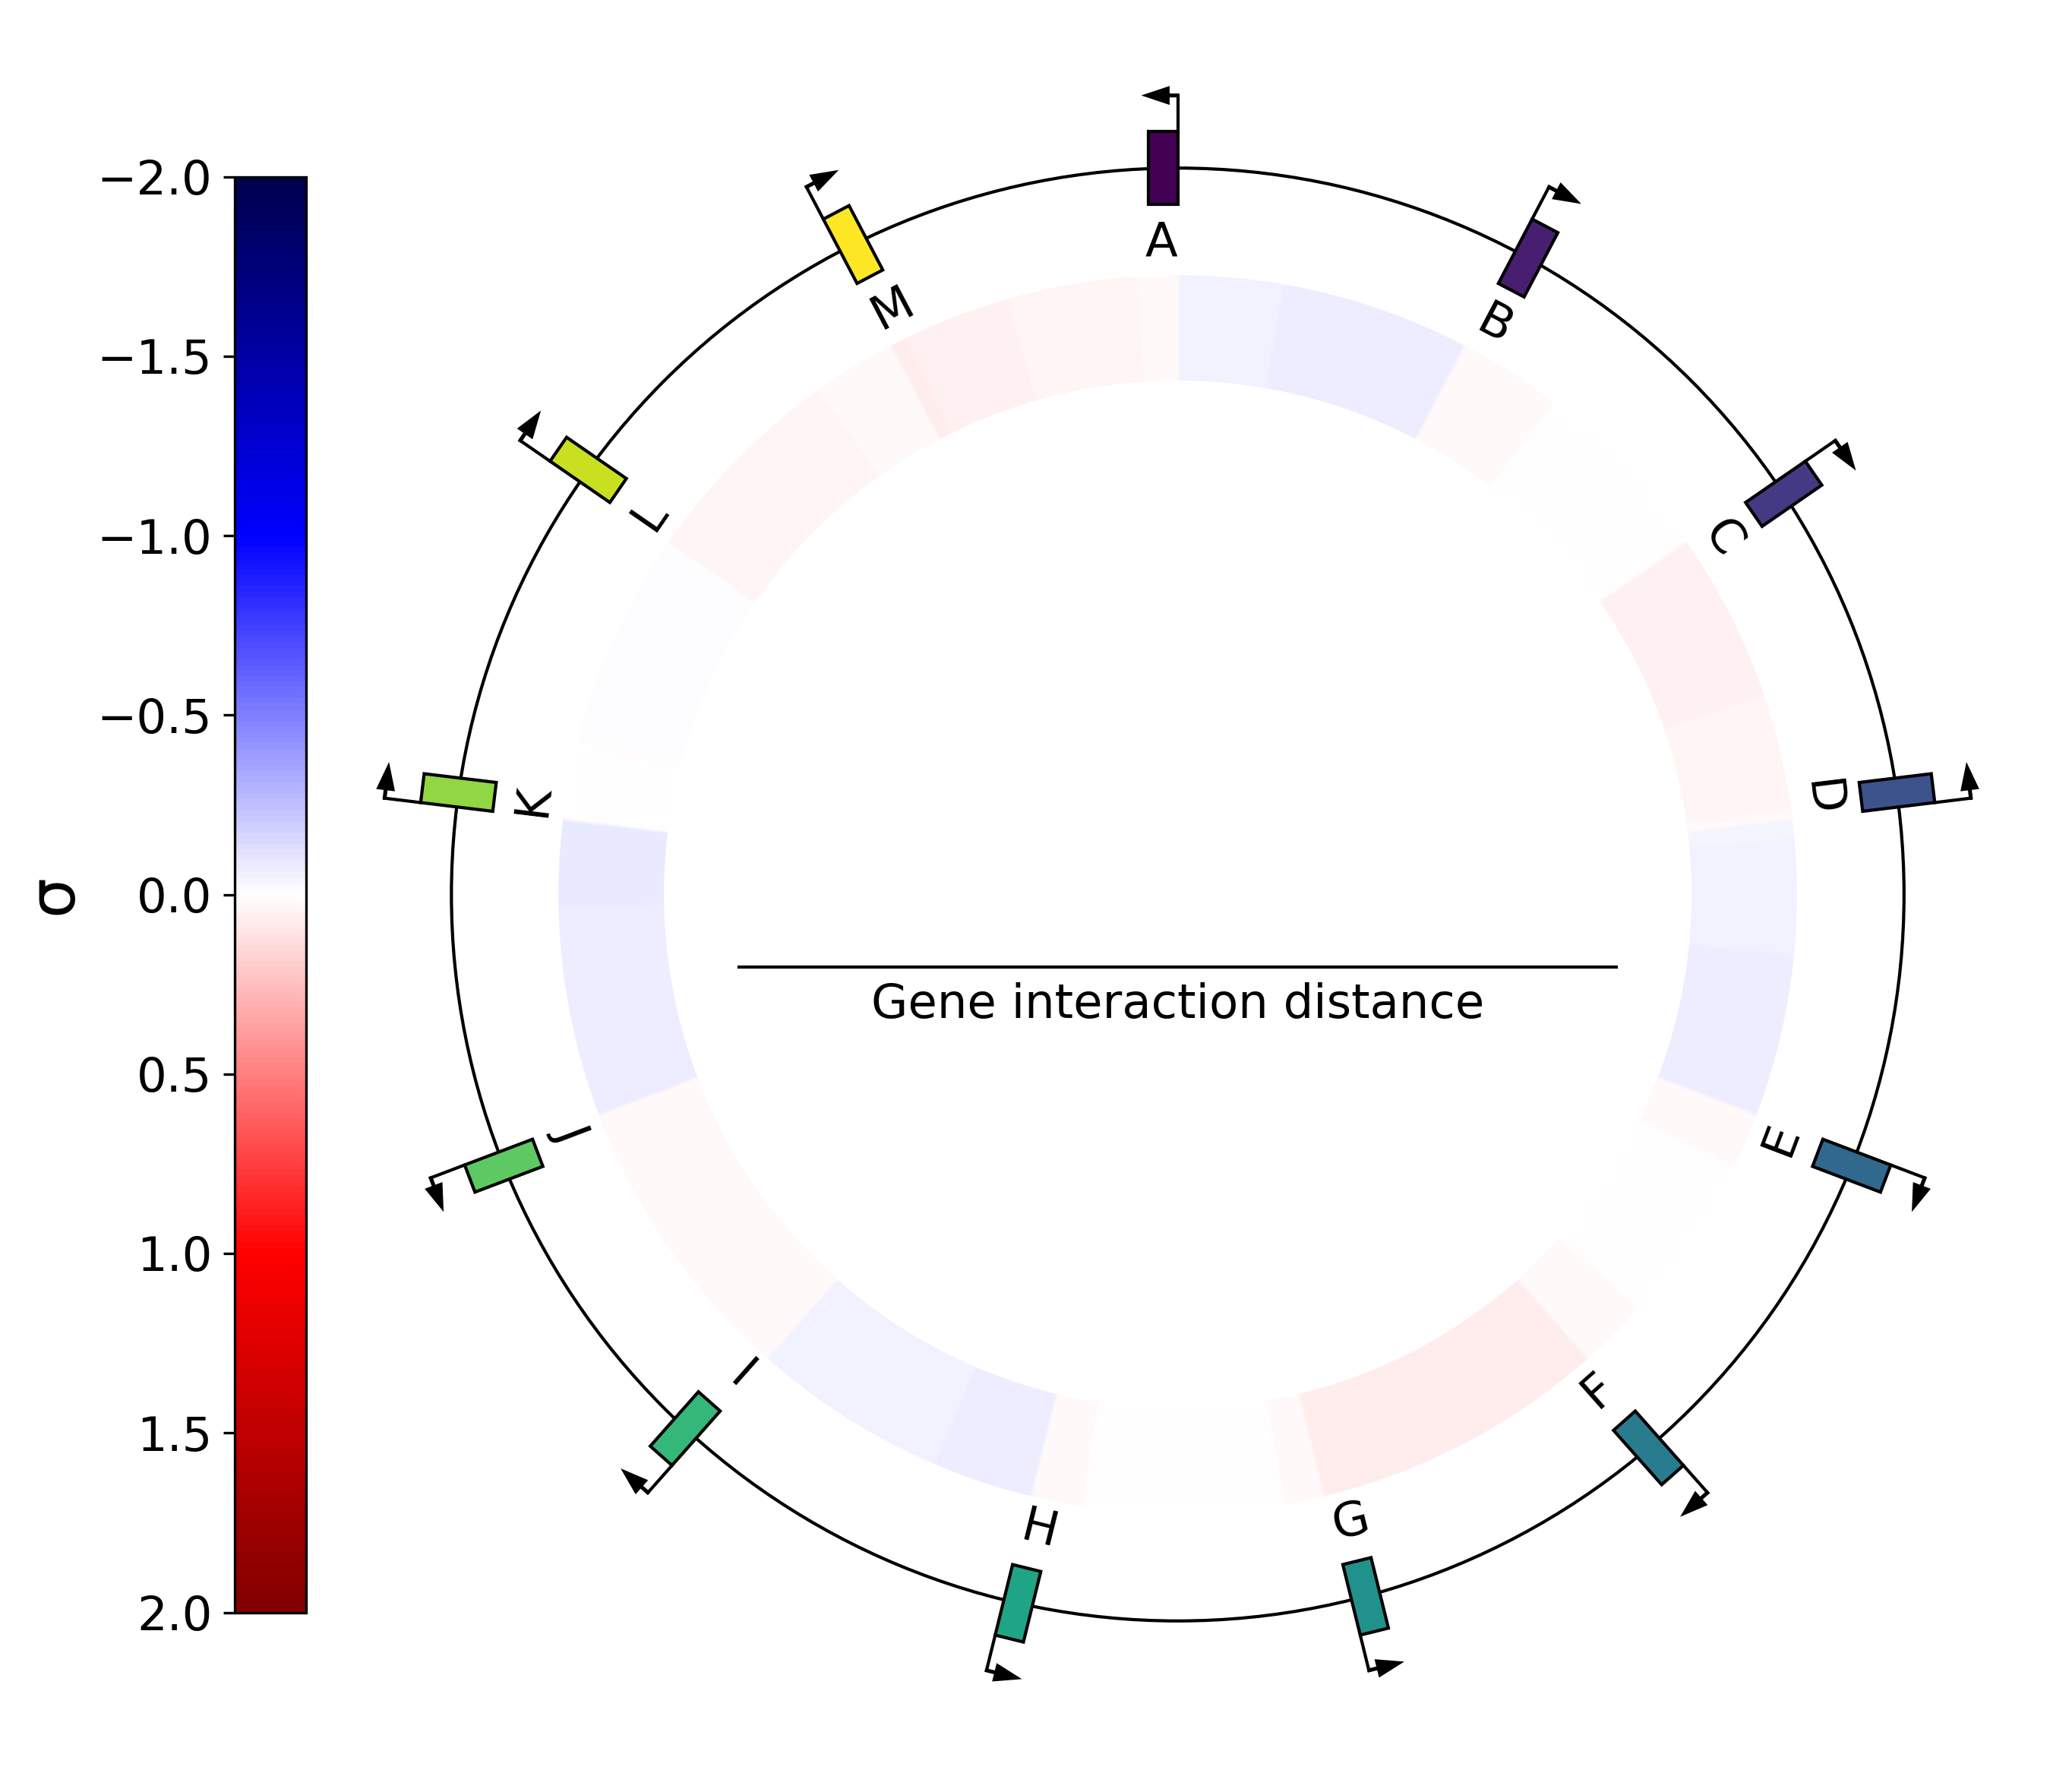

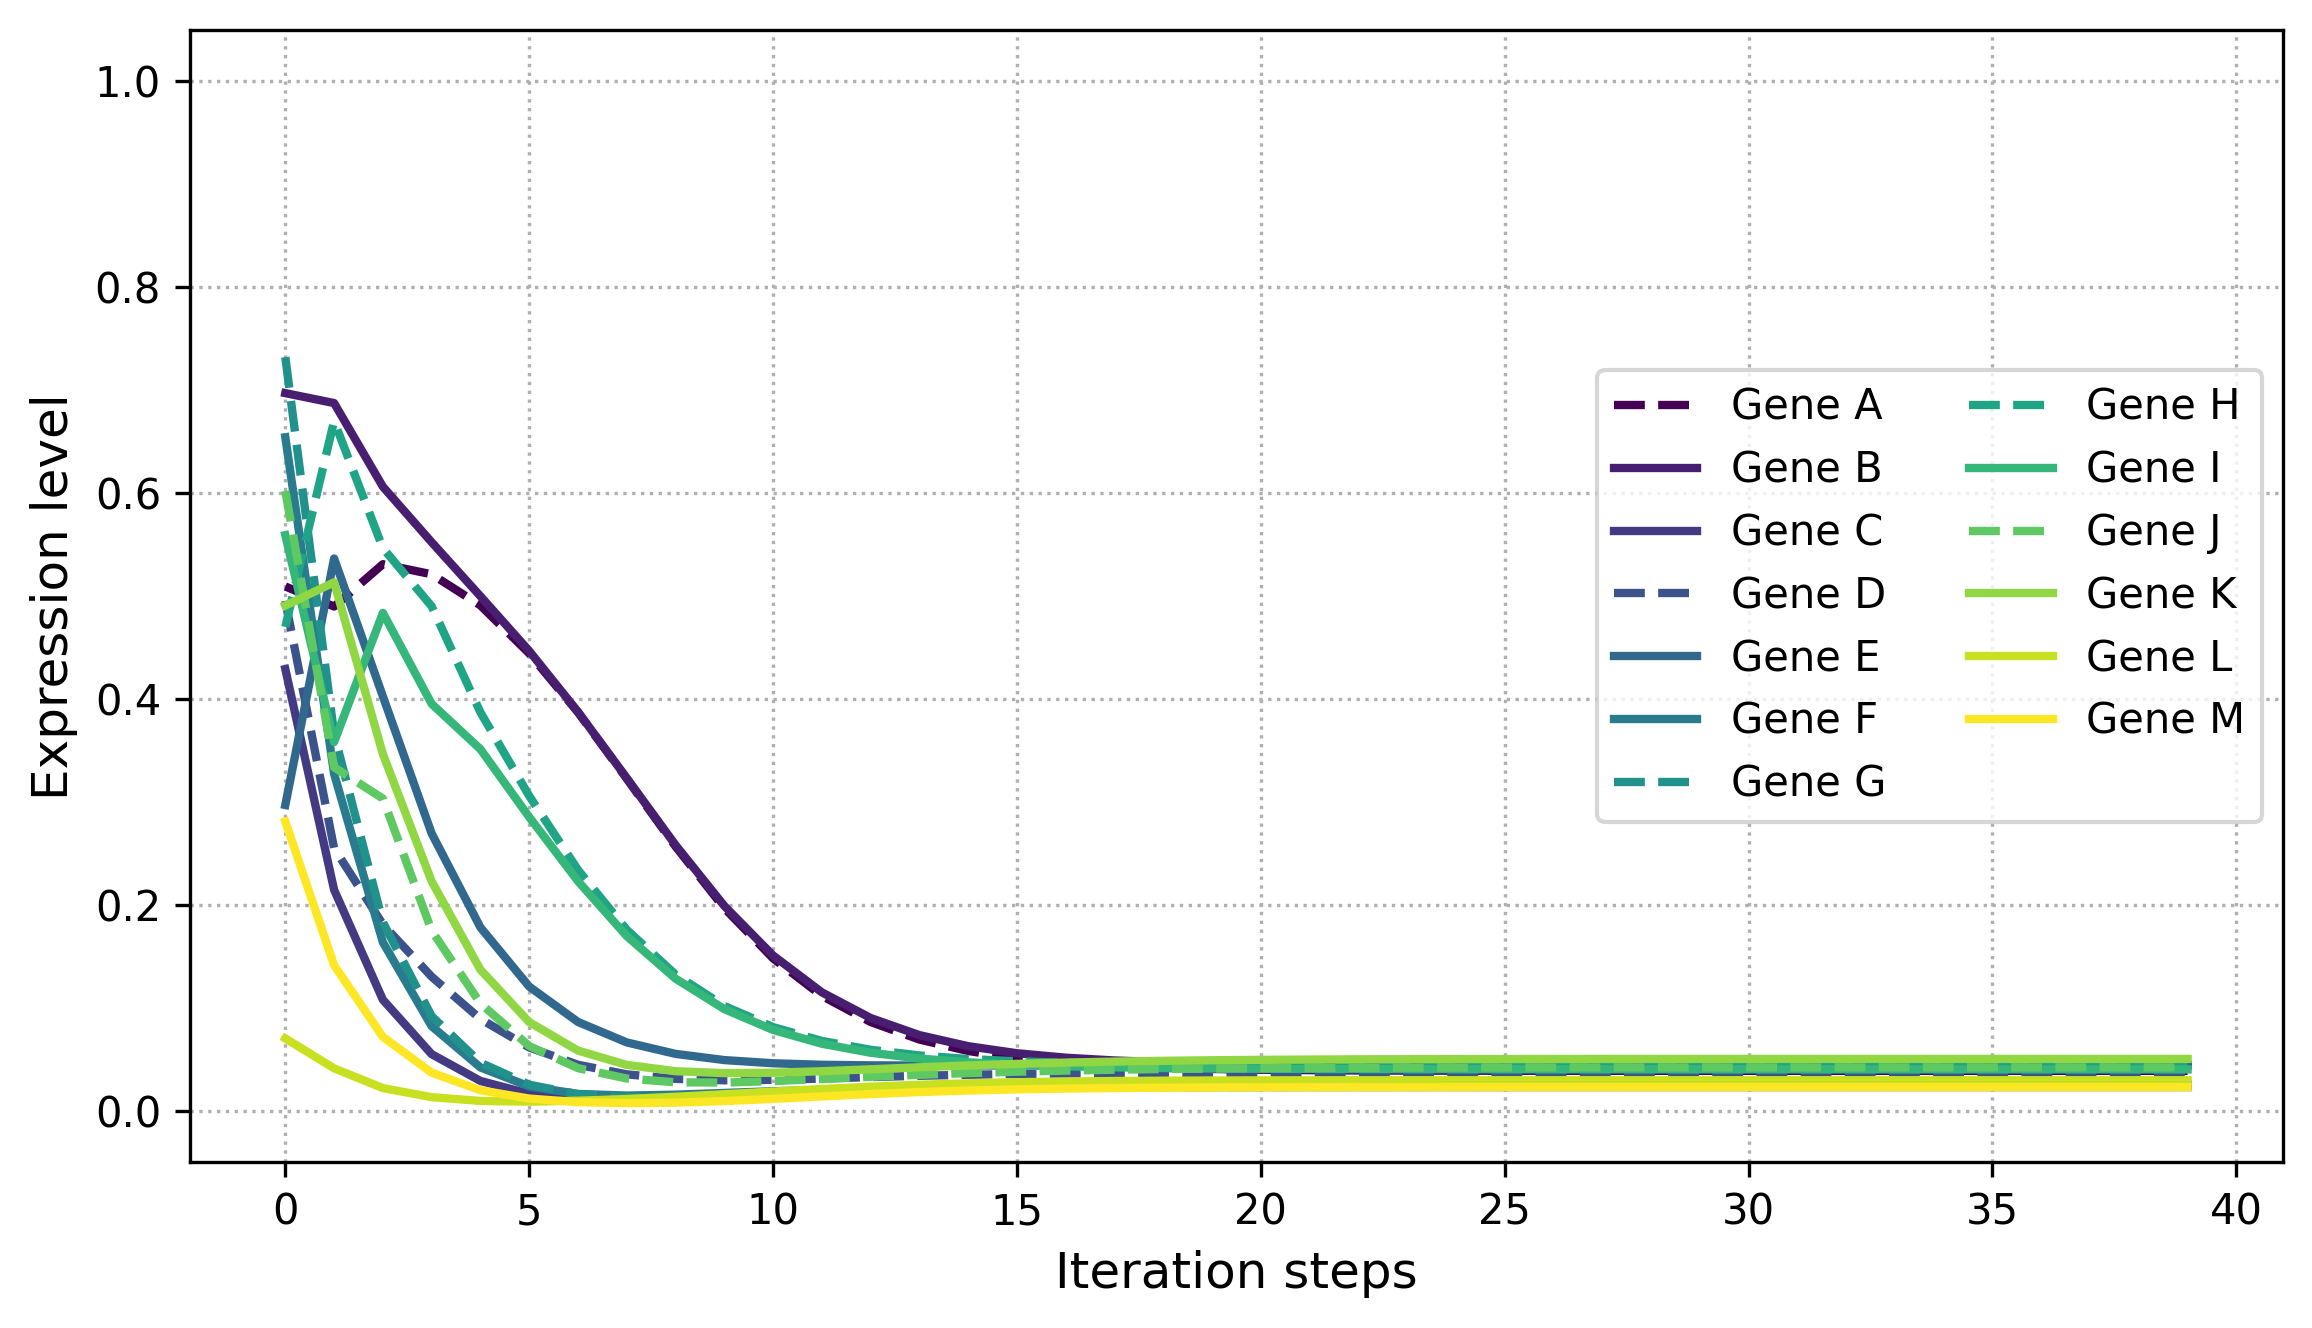

In [67]:
for i_sigma, sigma in enumerate([-0.2, -0.1, 0.0, 0.1]):
    expr = ex_indiv.run_system(sigma)
    nb_on = 0
    for i_gene in range(ex_indiv.nb_genes):
        if expr[i_gene, -1] > 0.5:
            nb_on += 1
            
    print(f'SC {sigma}: {nb_on} on')
    
    show_legend = (i_sigma == 3)
    
    plot_genome_and_tsc(ex_indiv, sigma, print_ids=True, name=f'13genes_genome_{i_sigma}.pdf')
    plot_expr(ex_indiv, expr, show_legend=show_legend, plot_name=f'13genes_sigma_{i_sigma}.pdf')

## Example individual: genomic inversion

In [60]:
indiv_inversion = ex_indiv.clone()

indiv_inversion.perform_inversion(start_pos=500, end_pos=2500)
indiv_inversion.already_evaluated = False
indiv_inversion.evaluate(sigma_ex, sigma_ex) # Recompute inter_matrix

((array([[5.09166978e-01, 2.54871242e-01, 1.30607887e-01, 8.07139593e-02,
          7.30753842e-02, 8.20643227e-02, 9.23782253e-02, 9.85415170e-02,
          9.97285390e-02, 9.72168863e-02, 9.30136500e-02, 8.88265584e-02,
          8.55838511e-02, 8.35157378e-02, 8.24463558e-02, 8.20550671e-02,
          8.20372012e-02, 8.21728487e-02, 8.23346611e-02, 8.24662175e-02,
          8.25538582e-02, 8.26038591e-02, 8.26282310e-02, 8.26378588e-02,
          8.26403151e-02, 8.26399924e-02, 8.26390236e-02, 8.26382210e-02,
          8.26377561e-02, 8.26375603e-02, 8.26375188e-02],
         [4.28926541e-01, 2.20861520e-01, 1.13256453e-01, 6.18984321e-02,
          3.94120870e-02, 3.17018794e-02, 3.12159266e-02, 3.35219076e-02,
          3.60925171e-02, 3.77982012e-02, 3.84665241e-02, 3.84004812e-02,
          3.79911922e-02, 3.75255519e-02, 3.71512522e-02, 3.69115172e-02,
          3.67916740e-02, 3.67552319e-02, 3.67654069e-02, 3.67946337e-02,
          3.68263005e-02, 3.68526316e-02, 3.68714952e

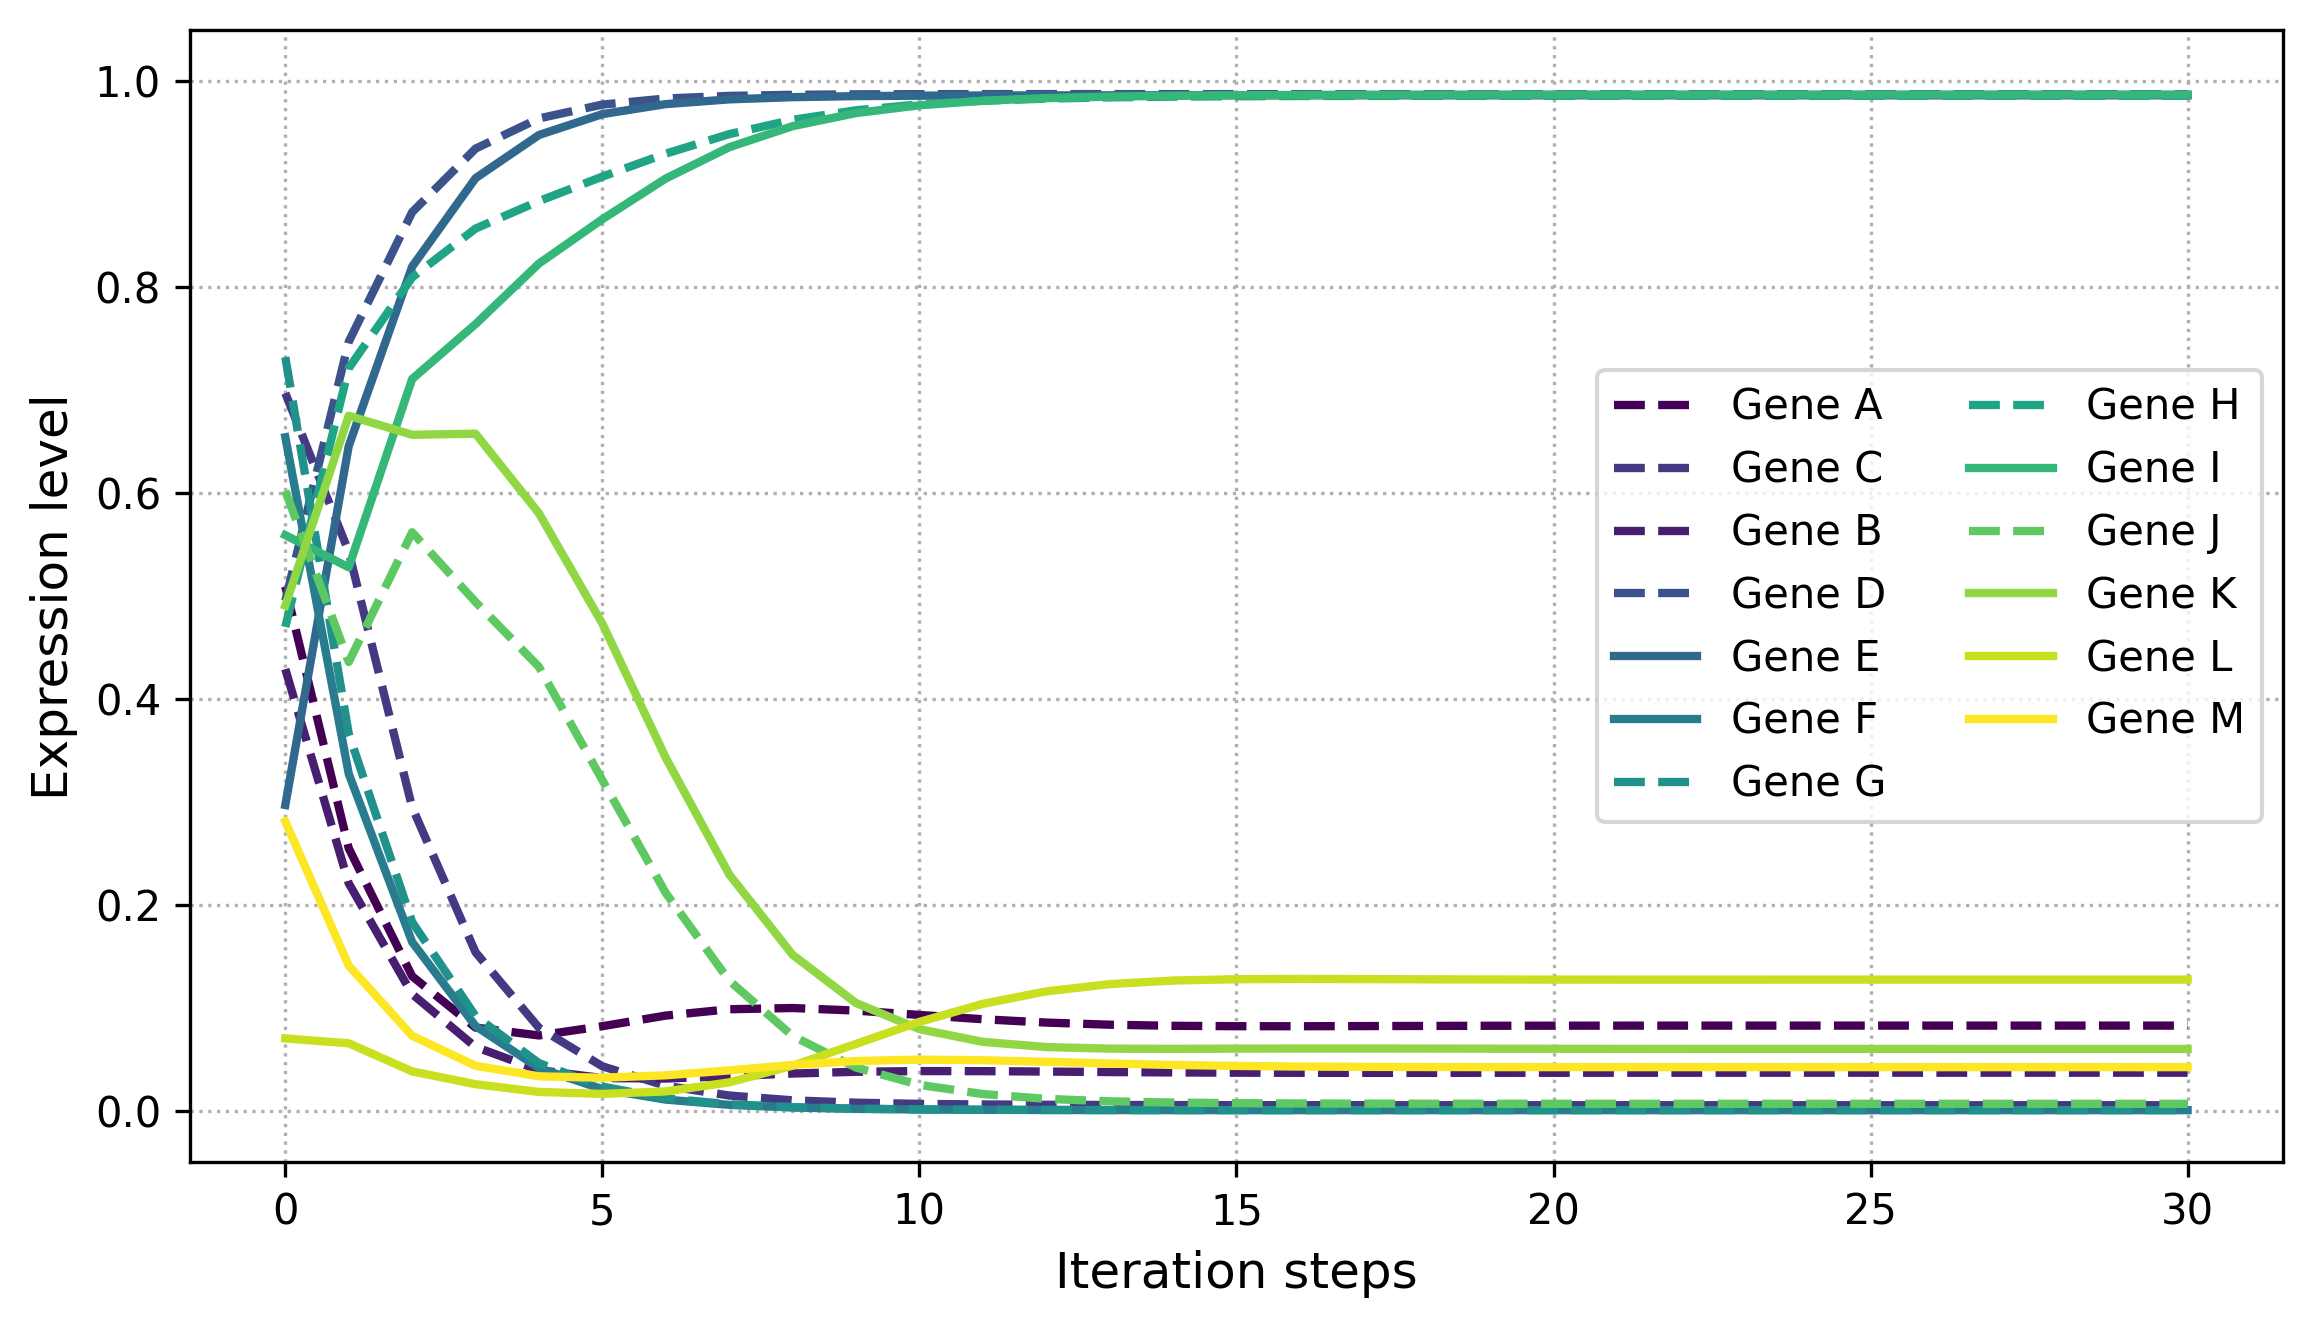

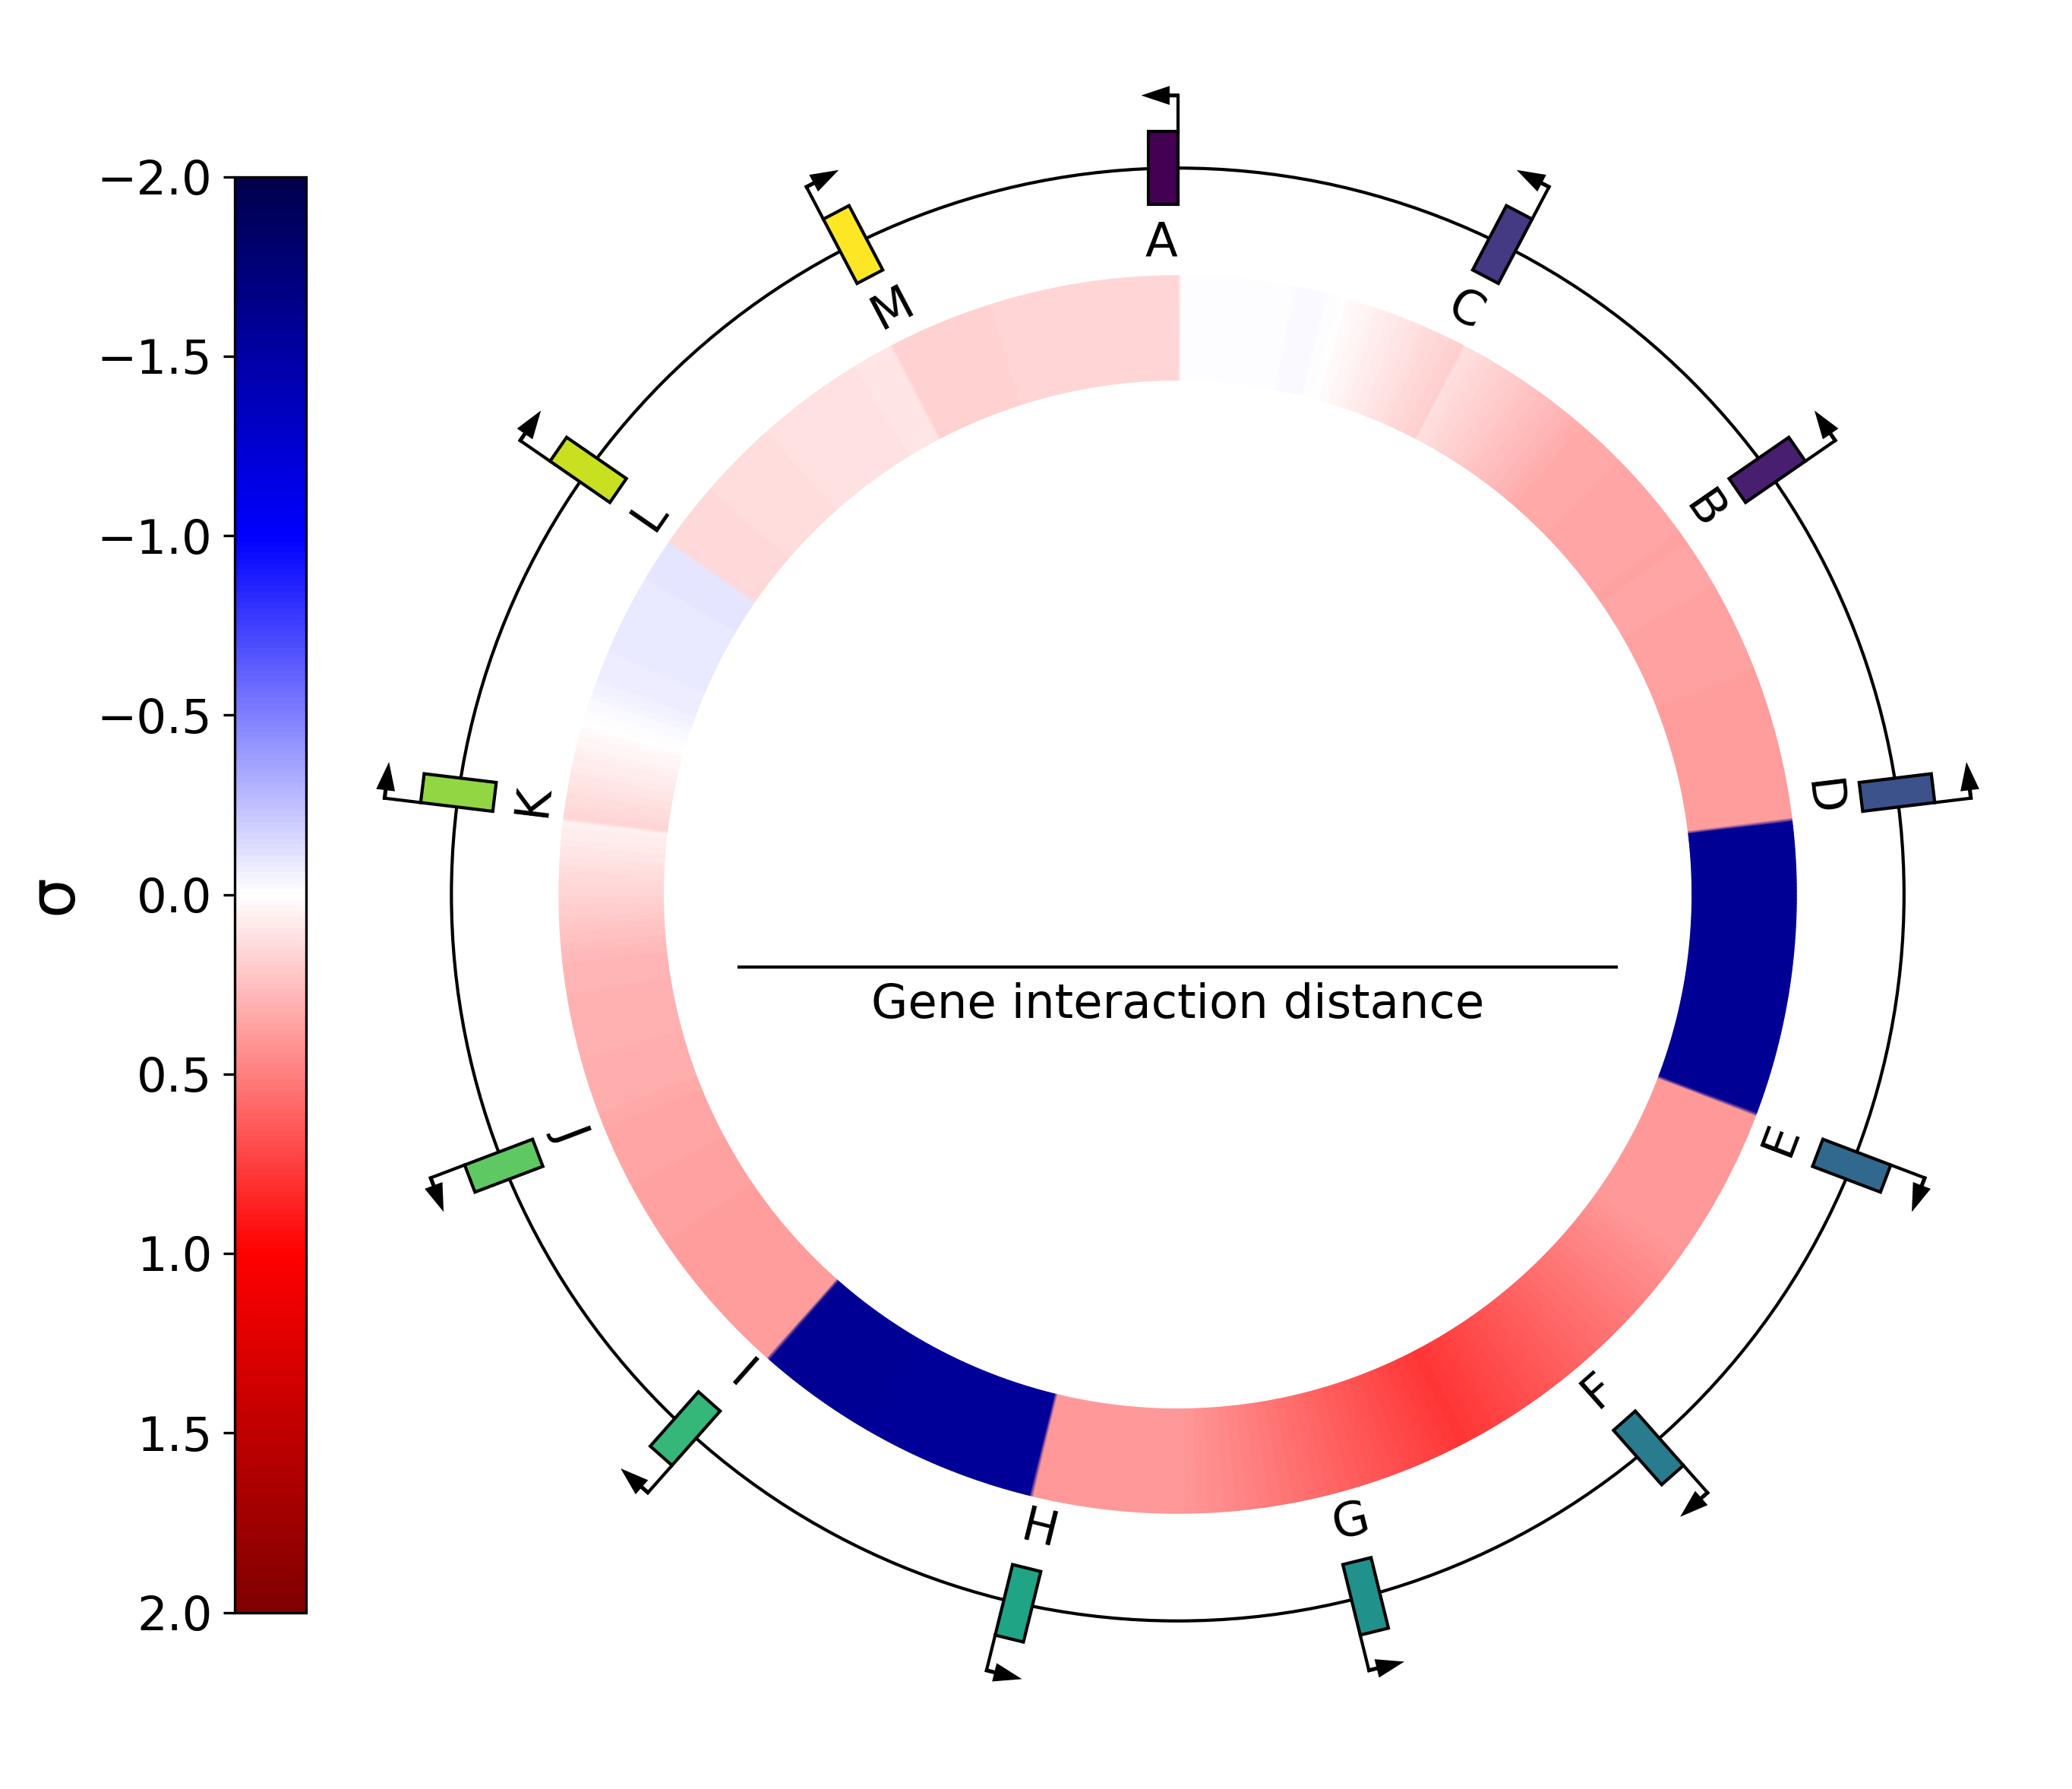

In [61]:
plot_expr(indiv_inversion, indiv_inversion.run_system(sigma_ex), plot_name='inversion_expr_level.pdf')
plot_genome_and_tsc(indiv_inversion, sigma_ex, print_ids=True, name='inversion_genome.pdf')

In [63]:
inv_expr = indiv_inversion.run_system(sigma_ex)